In [49]:
import os
import sys

cascade_path = r"F:\compneuro-project\Cascade"
os.chdir(cascade_path)

if cascade_path not in sys.path:
    sys.path.append(cascade_path)

# Now you can import Cascade modules
from cascade2p import checks
checks.check_packages()

from cascade2p import cascade
from cascade2p.utils import (
    plot_dFF_traces,
    plot_noise_level_distribution,
    plot_noise_matched_ground_truth
)
from cascade2p.cascade import predict
from cascade2p import utils


	YAML reader installed (version 0.18.13).
	Keras installed (version 2.4.3).
	Tensorflow installed (version 2.4.1).


In [50]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
df = pd.read_parquet(filename)
df.head(5)

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,ophys_session_id,ophys_container_id,behavior_session_id,full_genotype,reporter_line,driver_line,indicator,sex,age_in_days,exposure_level
85,5,1086496689,"[0.06366926431655884, 0.002476318972185254, -0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.006115,-0.084113,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
86,5,1086501573,"[0.0637083426117897, 0.0919334813952446, -0.09...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.018832,-0.025578,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
87,5,1086500533,"[0.0223990511149168, 0.22551870346069336, 0.11...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.041275,-0.032698,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
88,5,1086497438,"[0.01795899122953415, 0.15271763503551483, 0.0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.039527,-0.026750,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
89,5,1086497908,"[0.059766266494989395, 0.03602207452058792, 0....","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.006628,-0.039277,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar


In [51]:
import numpy as np

# Select a non-empty row with valid trace_timestamps
valid_row = df[df["trace_timestamps"].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) > 1)].iloc[0]
timestamps = np.array(valid_row["trace_timestamps"])

# Compute time intervals
intervals = np.diff(timestamps)
mean_interval = np.mean(intervals)
frame_rate = 1.0 / mean_interval

print(f"✅ Estimated Frame Rate: {frame_rate:.2f} Hz")


✅ Estimated Frame Rate: 30.94 Hz


In [52]:
import pandas as pd
import numpy as np



# Ensure trace is converted from string to numpy array if needed
def safe_convert_trace(trace):
    if isinstance(trace, list):
        return np.array(trace)
    elif isinstance(trace, str):
        try:
            return np.array(eval(trace))
        except:
            return np.array([])
    else:
        return np.array(trace)

df["trace"] = df["trace"].apply(safe_convert_trace)

# Drop rows with invalid or too-short traces
df = df[df["trace"].apply(lambda x: isinstance(x, np.ndarray) and len(x) > 10)].copy()

# Normalize cell types (cre_line) → classify as SST or VIP
def classify_cell_type(cre_line):
    if "Sst" in cre_line:
        return "SST"
    elif "Vip" in cre_line:
        return "VIP"
    else:
        return "Other"

df["cell_type"] = df["cre_line"].apply(classify_cell_type)
df = df[df["cell_type"].isin(["SST", "VIP"])]  # Filter only SST and VIP

# Drop any missing required fields
df = df.dropna(subset=["trace", "omitted", "exposure_level", "cell_type"])

# Create unique groups: 2 (SST/VIP) × 2 (familiar/novel) × 2 (omitted/False) = 8 groups
grouped_subsets = {}
group_names = []

for cell_type in ["SST", "VIP"]:
    for exposure in ["familiar", "novel"]:
        for omission in [True, False]:
            group_name = f"{cell_type}_{exposure}_{'omitted' if omission else 'shown'}"
            subset = df[
                (df["cell_type"] == cell_type) &
                (df["exposure_level"] == exposure) &
                (df["omitted"] == omission)
            ]
            if not subset.empty:
                grouped_subsets[group_name] = subset
                group_names.append(group_name)
                print(f"✅ Group: {group_name:30} | Rows: {len(subset)}")

# Example: access one group’s traces and cell IDs
example_group = "SST_familiar_omitted"
if example_group in grouped_subsets:
    traces = np.stack(grouped_subsets[example_group]["trace"].values)
    cell_ids = grouped_subsets[example_group]["cell_specimen_id"].values
    print("🎯 Sample group shape:", traces.shape)


✅ Group: SST_familiar_omitted           | Rows: 18212
✅ Group: SST_familiar_shown             | Rows: 25380
✅ Group: SST_novel_omitted              | Rows: 6919
✅ Group: SST_novel_shown                | Rows: 8970
✅ Group: VIP_familiar_omitted           | Rows: 21639
✅ Group: VIP_familiar_shown             | Rows: 28121
✅ Group: VIP_novel_omitted              | Rows: 14963
✅ Group: VIP_novel_shown                | Rows: 23491
🎯 Sample group shape: (18212, 85)


In [54]:
grouped_subsets['SST_familiar_omitted']



,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,ophys_container_id,behavior_session_id,full_genotype,reporter_line,driver_line,indicator,sex,age_in_days,exposure_level,cell_type
187,11,1086496689,"[0.08654665946960449, 0.14293967187404633, -0....","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.054434,-0.013710,omitted,8,False,True,...,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar,SST
188,11,1086501573,"[0.11211464554071426, 0.15181204676628113, 0.1...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.004320,-0.010285,omitted,8,False,True,...,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar,SST
189,11,1086500533,"[0.10292566567659378, 0.08875970542430878, 0.0...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.015785,0.040365,omitted,8,False,True,...,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar,SST
190,11,1086497438,"[0.052102770656347275, -0.09986802190542221, 0...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.042692,0.044973,omitted,8,False,True,...,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar,SST
191,11,1086497908,"[0.01246928982436657, 0.13261471688747406, -0....","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.015286,0.029058,omitted,8,False,True,...,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar,SST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560623,4785,1086490751,"[0.03288273513317108, 0.01249674241989851, -0....","[-1.227931560317585, -1.195617571888175, -1.16...",0.000418,-0.008633,omitted,8,False,True,...,978206330,985792625,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,152.0,familiar,SST
1560652,4793,1086490807,"[-0.012235157191753387, 0.11768049001693726, 0...","[-1.227931560317585, -1.195617571888175, -1.16...",-0.023444,-0.008104,omitted,8,False,True,...,978206330,985792625,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,152.0,familiar,SST
1560653,4793,1086490603,"[0.12911705672740936, 0.07650244235992432, 0.0...","[-1.227931560317585, -1.195617571888175, -1.16...",-0.010739,-0.021409,omitted,8,False,True,...,978206330,985792625,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,152.0,familiar,SST
1560654,4793,1086490696,"[-0.011452607810497284, -0.030517740175127983,...","[-1.227931560317585, -1.195617571888175, -1.16...",-0.009479,0.001601,omitted,8,False,True,...,978206330,985792625,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,152.0,familiar,SST


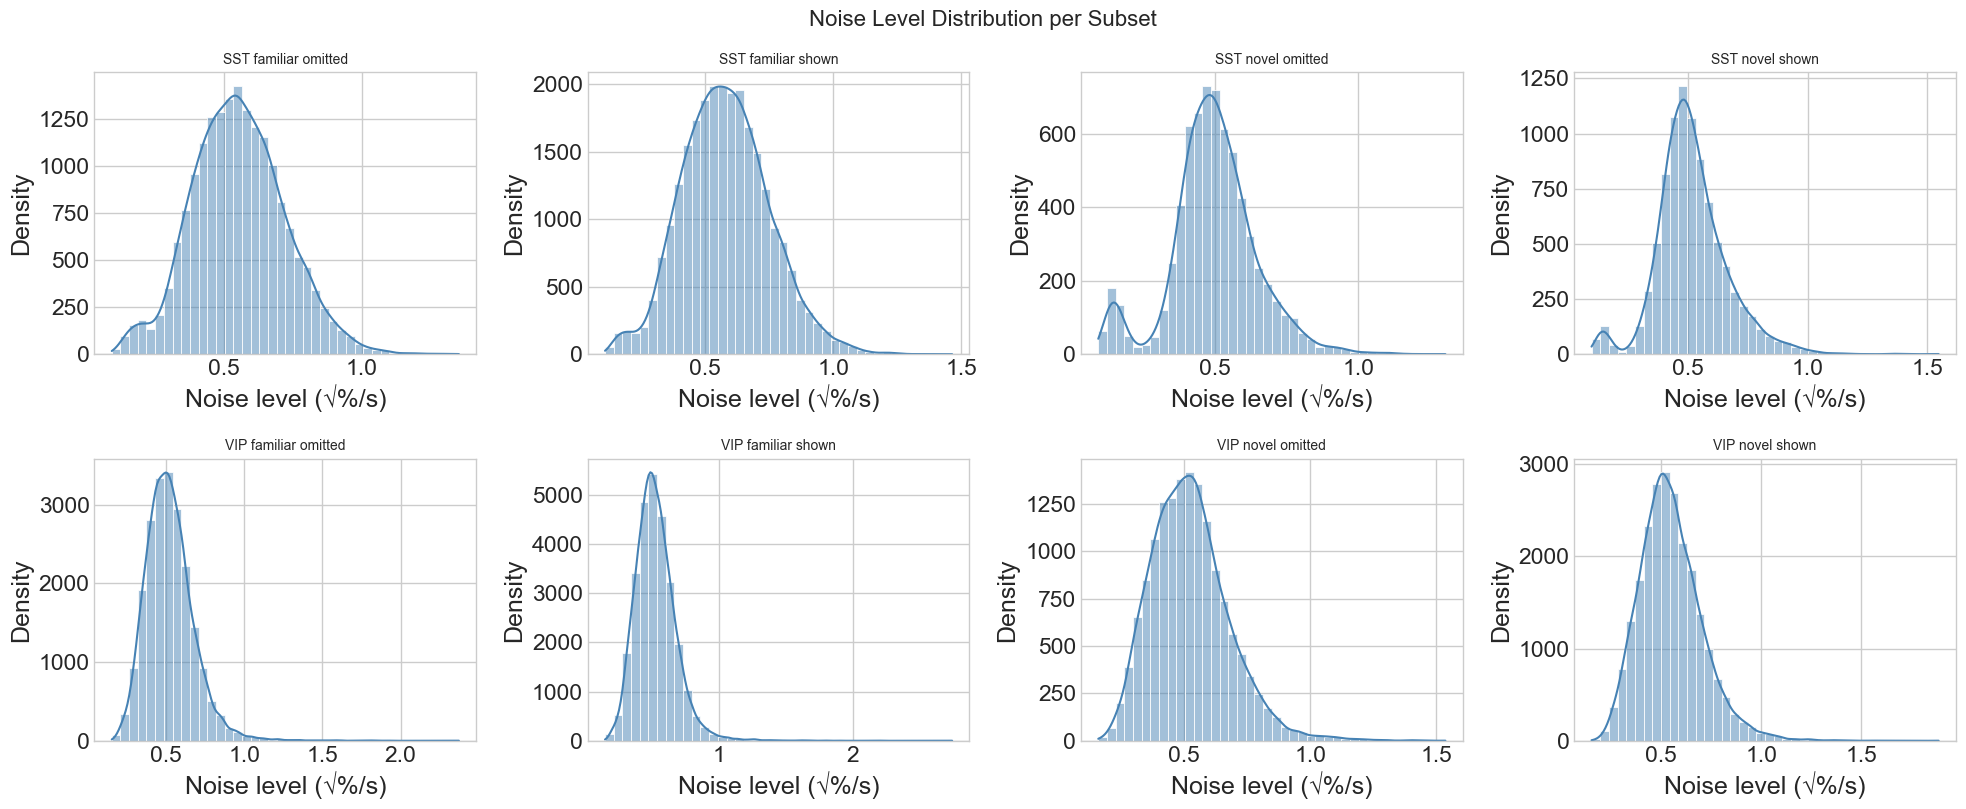

In [55]:
import numpy as np

def estimate_trace_noise_levels(traces, frame_rate=30):
    """
    Estimate noise levels for calcium traces based on median absolute deviation.
    Output is in sqrt(%/s) as required by Cascade conventions.
    """
    if traces.ndim != 2:
        raise ValueError("Expected a 2D array (n_cells x n_frames) for traces.")

    diffs = np.diff(traces, axis=1) * np.sqrt(frame_rate)
    mad = np.median(np.abs(diffs - np.median(diffs, axis=1, keepdims=True)), axis=1)
    return 1.4826 * mad  # 1.4826 = scale factor to convert MAD to std dev (assuming Gaussian)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings



warnings.filterwarnings("ignore")
plt.style.use("seaborn-whitegrid")

# Frame rate used in your data (e.g., 30 Hz)
frame_rate = 30

# Prepare figure
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

# Loop through groups
for idx, (key, group) in enumerate(grouped_subsets.items()):
    ax = axes[idx]
    traces_array = np.stack(group["trace"].values)

    # Estimate noise levels
    noise_levels = estimate_trace_noise_levels(traces_array, frame_rate=frame_rate)

    # Plot histogram manually
    sns.histplot(noise_levels, ax=ax, kde=True, bins=40, color="steelblue")
    ax.set_title(key.replace("_", " "), fontsize=10)
    ax.set_xlabel("Noise level (√%/s)")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.suptitle("Noise Level Distribution per Subset", y=1.02, fontsize=16)
plt.show()


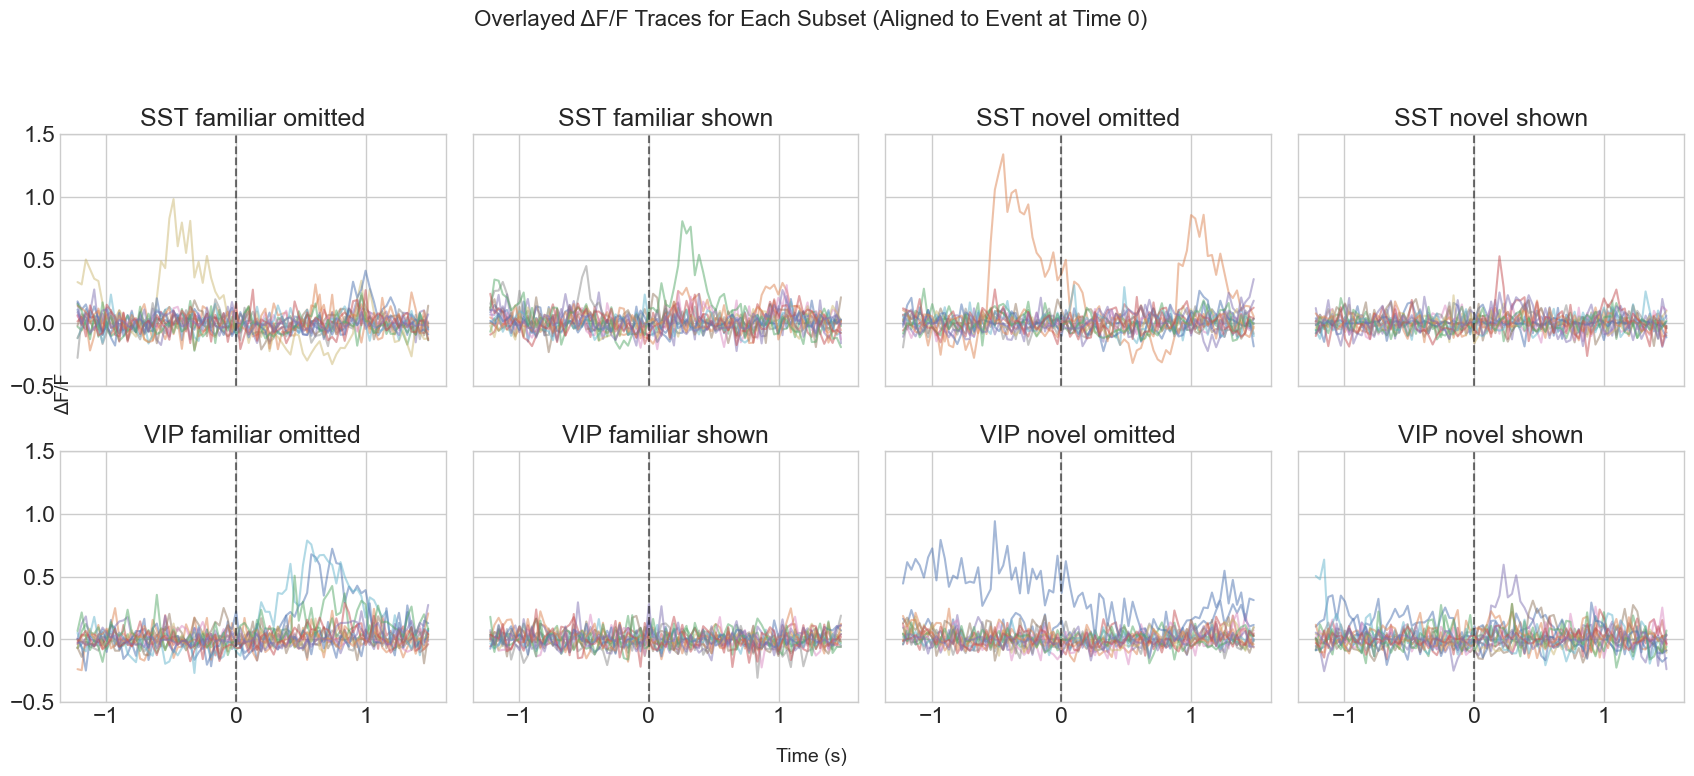

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Set global plot config
plt.rcParams['figure.figsize'] = [18, 10]
np.random.seed(42)  # for reproducibility

# Use your 30Hz sampling and fixed duration
frame_rate = 30
n_timepoints = 85  # should match the length of each trace
time_axis = np.linspace(-1.22, 1.48, n_timepoints)

# 2x4 subplot setup
fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (key, group) in enumerate(grouped_subsets.items()):
    ax = axes[i]

    # Extract traces (assume already np.array)
    traces_array = np.stack(group["trace"].values)

    # Randomly sample up to 15 neurons
    n_cells = min(15, traces_array.shape[0])
    idx = np.random.choice(traces_array.shape[0], size=n_cells, replace=False)

    # Plot each trace in the selected group
    for j in idx:
        ax.plot(time_axis, traces_array[j], alpha=0.5)

    # Format plot
    ax.set_title(key.replace("_", " "))
    ax.axvline(0, color='k', linestyle='--', alpha=0.6)  # Event marker
    ax.set_ylim(-0.5, 1.5)

# Common labels
fig.text(0.5, 0.04, 'Time (s)', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'ΔF/F', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Overlayed ΔF/F Traces for Each Subset (Aligned to Event at Time 0)", fontsize=16)
plt.tight_layout(rect=[0.04, 0.05, 1, 0.95])
plt.show()


In [58]:
from cascade2p.cascade import predict

# Inference model for inhibitory cell types
model_name = "Global_INH_30Hz_smoothing50ms"
model_folder = "Pretrained_models"

# Store results
spike_predictions = {}

# Loop through each of the 8 groups
for key, group in grouped_subsets.items():
    print(f"\n🔁 Running Cascade on group: {key} | Rows: {len(group)}")

    # Drop duplicates to ensure unique cell traces
    unique_group = group

    # Extract trace matrix
    dff_traces = np.stack(unique_group["trace"].values)

    # Skip if no valid traces
    if dff_traces.shape[0] == 0:
        print(f"⚠️ Skipping {key}: No valid traces")
        continue

    # Predict spikes
    try:
        Y_predict = predict(
            model_name=model_name,
            traces=dff_traces,
            model_folder=model_folder,
            threshold=1,
            padding=0,
            trace_noise_levels=None,  # Could be estimated later
            verbosity=1
        )
        spike_predictions[key] = {
            "cell_ids": unique_group["cell_specimen_id"].values,
            "spikes": Y_predict
        }
        print(f"✅ Finished: {key} | Spikes shape: {Y_predict.shape}")
    except Exception as e:
        print(f"❌ Error running Cascade on {key}: {e}")



🔁 Running Cascade on group: SST_familiar_omitted | Rows: 18212

 
The selected model was trained on 6 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 18212 neurons and 85 frames.
Noise levels (mean, std; in standard units): 1.25, 0.38

Predictions for noise level 2:
	... ensemble 0
1509/1509 [==============================] - 61s 38ms/step
	... ensemble 1
1509/1509 [==============================] - 45s 30ms/step
	... ensemble 2
1509/1509 [==============================] - 46s 30ms/step
	... ensemble 3
1509/1509 [==============================] - 45s 30ms/step
	... ensemble 4
1509/1509 [==============================] - 47s 31ms/step

Predictions for noise level 3:
	... ensemble 0
3/3 [==============================] - 1s 41ms/step
	... ensemble 1
3/3 [============

In [84]:
spike_predictions

{'SST_familiar_omitted': {'cell_ids': array([1086496689, 1086501573, 1086500533, ..., 1086490603, 1086490696,
         1086490751], dtype=int64),
  'spikes': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])},
 'SST_familiar_shown': {'cell_ids': array([1086496689, 1086501573, 1086500533, ..., 1086490603, 1086490696,
         1086490751], dtype=int64),
  'spikes': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])},
 'SST_novel_omitted': {'cell_ids': array([1086497034, 1086497129, 1086496500, ..., 1086490751, 1086490807,
         1086490603], dtype=int64),
  'spikes': array([[0., 0., 0., .

In [71]:
import os
import numpy as np
import scipy.io as sio

# Output folder
output_folder = "cascade_predictions_output"
os.makedirs(output_folder, exist_ok=True)

# Loop through prediction results
for key, result in spike_predictions.items():
    spike_prob = result["spikes"]
    cell_ids = result["cell_ids"]

    # Create filename base (safe name)
    safe_key = key.replace(" ", "_")
    base_filename = f"predictions_{safe_key}"

    # Save as .npy file
    npy_path = os.path.join(output_folder, base_filename + ".npy")
    np.save(npy_path, spike_prob)

    # Save as .mat file
    mat_path = os.path.join(output_folder, base_filename + ".mat")
    sio.savemat(mat_path, {'spike_prob': spike_prob, 'cell_ids': cell_ids})

    print(f"✅ Saved: {npy_path} and {mat_path}")

✅ Saved: cascade_predictions_output\predictions_SST_familiar_omitted.npy and cascade_predictions_output\predictions_SST_familiar_omitted.mat
✅ Saved: cascade_predictions_output\predictions_SST_familiar_shown.npy and cascade_predictions_output\predictions_SST_familiar_shown.mat
✅ Saved: cascade_predictions_output\predictions_SST_novel_omitted.npy and cascade_predictions_output\predictions_SST_novel_omitted.mat
✅ Saved: cascade_predictions_output\predictions_SST_novel_shown.npy and cascade_predictions_output\predictions_SST_novel_shown.mat
✅ Saved: cascade_predictions_output\predictions_VIP_familiar_omitted.npy and cascade_predictions_output\predictions_VIP_familiar_omitted.mat
✅ Saved: cascade_predictions_output\predictions_VIP_familiar_shown.npy and cascade_predictions_output\predictions_VIP_familiar_shown.mat
✅ Saved: cascade_predictions_output\predictions_VIP_novel_omitted.npy and cascade_predictions_output\predictions_VIP_novel_omitted.mat
✅ Saved: cascade_predictions_output\predict

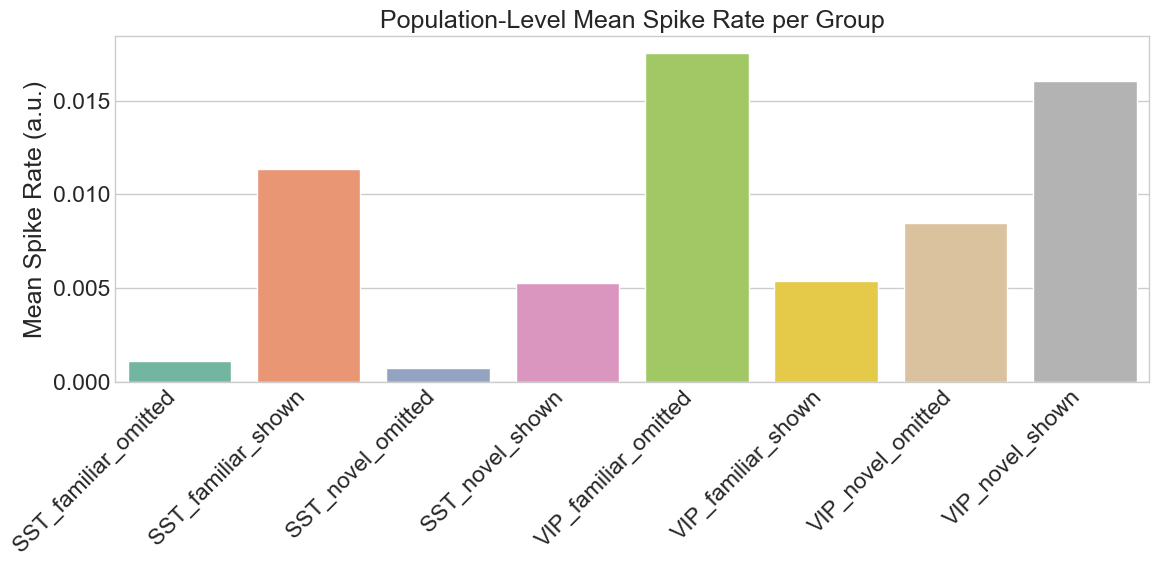

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect mean rates
group_means = []
group_labels = []

for group, data in spike_predictions.items():
    spikes = data["spikes"]  # shape: (n_neurons, n_timepoints)
    mean_rates = spikes.mean(axis=1)  # average over time, per neuron
    population_mean = mean_rates.mean()  # average over neurons
    group_means.append(population_mean)
    group_labels.append(group)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=group_labels, y=group_means, palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Spike Rate (a.u.)")
plt.title("Population-Level Mean Spike Rate per Group")
plt.tight_layout()
plt.show()


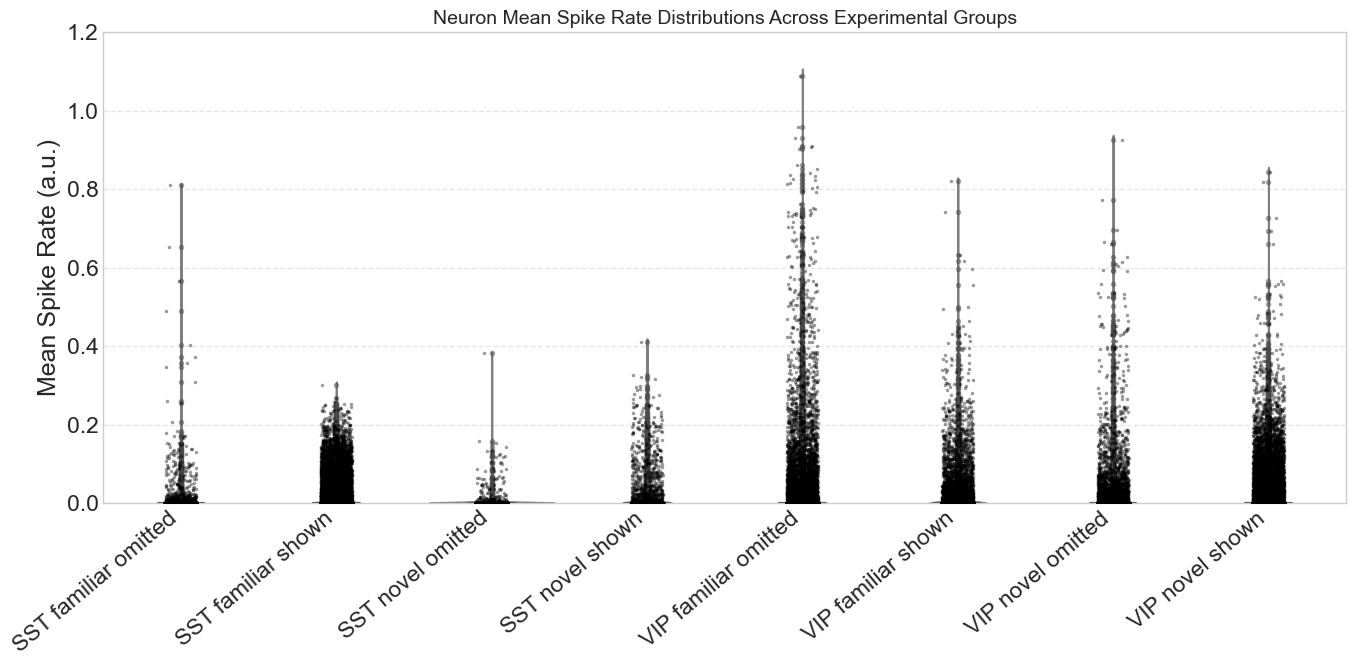

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create long-format DataFrame
all_data = []

for group, data in spike_predictions.items():
    spikes = data["spikes"]
    mean_rates = spikes.mean(axis=1)
    for rate in mean_rates:
        all_data.append({
            "Group": group.replace("_", " "),  # Make labels more readable
            "Mean Spike Rate": rate
        })

df_rates = pd.DataFrame(all_data)

# Step 2: Plot
plt.figure(figsize=(14, 7))

# Violin for distribution shape
sns.violinplot(data=df_rates, x="Group", y="Mean Spike Rate", inner=None, color="lightgray")

# Boxplot on top
sns.boxplot(data=df_rates, x="Group", y="Mean Spike Rate", width=0.3, showcaps=True,
            boxprops={'facecolor':'white', 'edgecolor':'black'},
            whiskerprops={'color':'black'}, flierprops={'marker': 'o', 'markersize': 3, 'alpha': 0.4})

# Add individual data points
sns.stripplot(data=df_rates, x="Group", y="Mean Spike Rate", jitter=True, size=2.5, color="black", alpha=0.4)

# Final formatting
plt.xticks(rotation=40, ha="right")
plt.ylim(0, 1.2)
plt.title("Neuron Mean Spike Rate Distributions Across Experimental Groups", fontsize=14)
plt.ylabel("Mean Spike Rate (a.u.)")
plt.xlabel("")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


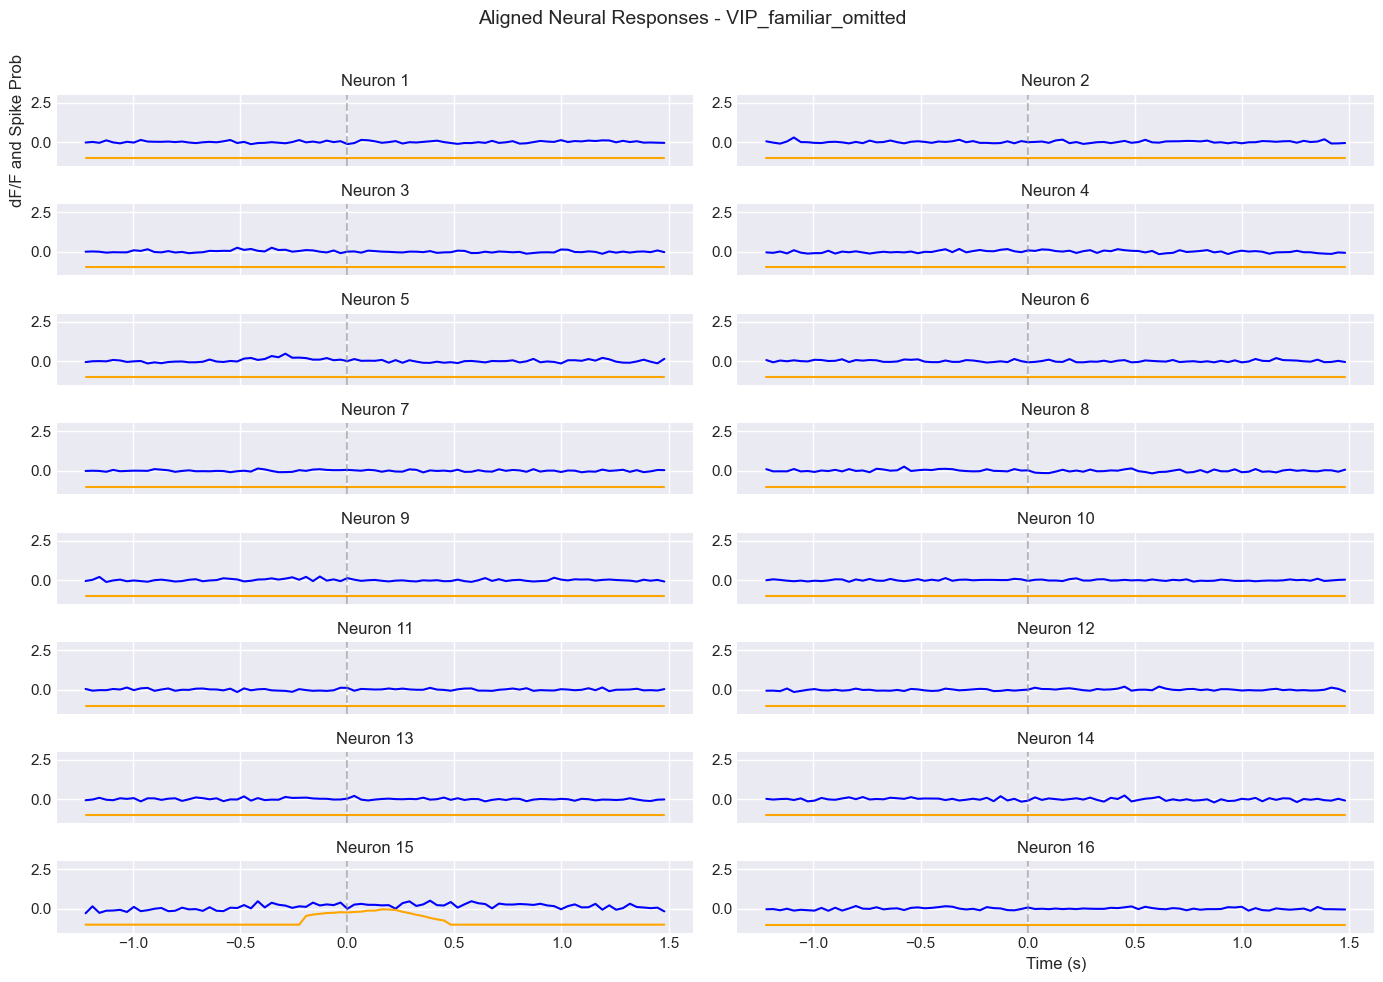

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Define settings
frame_rate = 30
nb_neurons = 16
time_axis = np.linspace(-1.22, 1.48, 85)  # Your aligned trace window

sample_key = "VIP_familiar_omitted"  # Pick any of your 8 subsets
sample_group = grouped_subsets[sample_key]

# Extract trace and prediction arrays
traces = np.stack(sample_group["trace"].values[:nb_neurons])  # shape: (n, 85)
spikes = spike_predictions[sample_key]["spikes"][:nb_neurons, :]  # shape: (n, 85)

# Plotting
fig, axes = plt.subplots(nb_neurons // 2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i in range(nb_neurons):
    ax = axes[i]
    ax.plot(time_axis, traces[i], label='dF/F', color='blue')
    ax.plot(time_axis, spikes[i] - 1, label='Spikes', color='orange')  # Shifted for visibility
    ax.set_ylim(-1.5, 3)
    ax.set_title(f"Neuron {i+1}")
    ax.axvline(0, linestyle='--', color='gray', alpha=0.5)

axes[0].set_ylabel("dF/F and Spike Prob")
axes[-1].set_xlabel("Time (s)")
plt.suptitle(f"Aligned Neural Responses - {sample_key}", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [83]:
df_rates

,Group,Mean Spike Rate
0,SST familiar omitted,0.000000
1,SST familiar omitted,0.000000
2,SST familiar omitted,0.000000
3,SST familiar omitted,0.000000
4,SST familiar omitted,0.000000
...,...,...
147690,VIP novel shown,0.069605
147691,VIP novel shown,0.000000
147692,VIP novel shown,0.000000
147693,VIP novel shown,0.059086


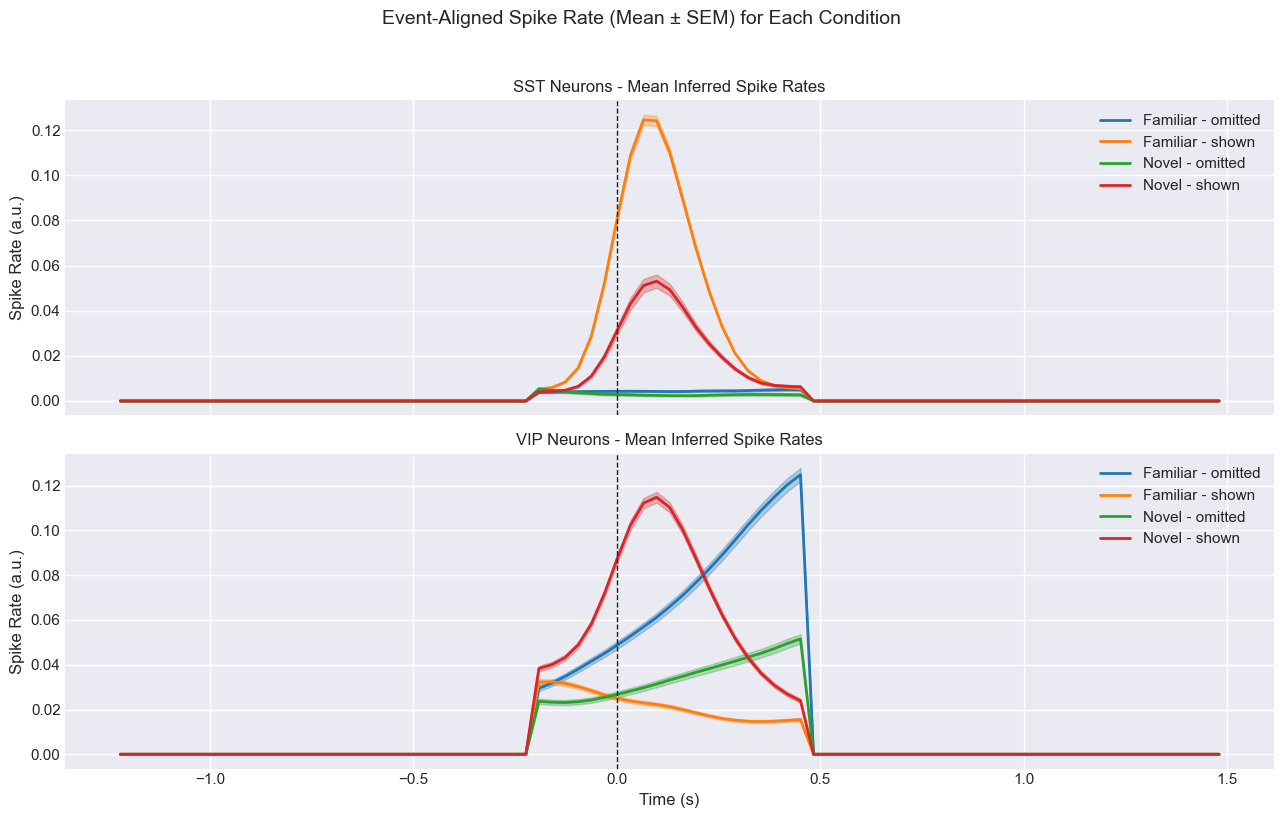

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

# Define color palette
colors = {
    "familiar_omitted": "#1f77b4",  # blue
    "familiar_shown": "#ff7f0e",    # orange
    "novel_omitted": "#2ca02c",     # green
    "novel_shown": "#d62728",       # red
}

# Correct time axis for 85 frames from -1.22 to +1.48s
time = np.linspace(-1.22, 1.48, 85)

# Initialize figure
fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)
cell_types = ['SST', 'VIP']

for ax, cell_type in zip(axes, cell_types):
    for exposure in ['familiar', 'novel']:
        for omitted, label in zip([True, False], ['omitted', 'shown']):
            key = f"{cell_type}_{exposure}_{label}"
            if key in spike_predictions:
                spikes = spike_predictions[key]['spikes']  # shape: (n_neurons, n_timepoints)
                mean_spike = np.mean(spikes, axis=0)
                error_band = sem(spikes, axis=0)

                ax.plot(time, mean_spike, label=f"{exposure.capitalize()} - {label}",
                        color=colors[f"{exposure}_{label}"], linewidth=2)
                ax.fill_between(time, mean_spike - error_band, mean_spike + error_band,
                                color=colors[f"{exposure}_{label}"], alpha=0.3)

    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    ax.set_title(f"{cell_type} Neurons - Mean Inferred Spike Rates")
    ax.set_ylabel("Spike Rate (a.u.)")
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel("Time (s)")
plt.suptitle("Event-Aligned Spike Rate (Mean ± SEM) for Each Condition", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


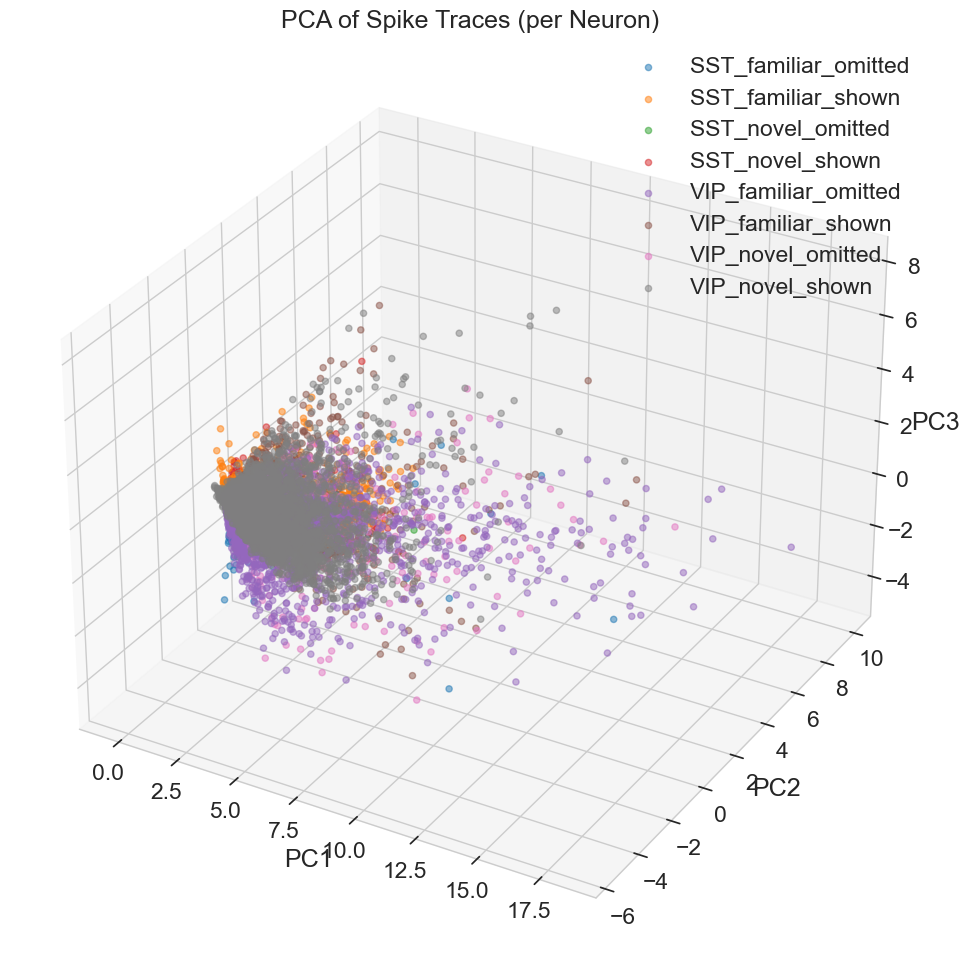

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# For consistent color
colors = {
    "SST_familiar_omitted": "#1f77b4",
    "SST_familiar_shown": "#ff7f0e",
    "SST_novel_omitted": "#2ca02c",
    "SST_novel_shown": "#d62728",
    "VIP_familiar_omitted": "#9467bd",
    "VIP_familiar_shown": "#8c564b",
    "VIP_novel_omitted": "#e377c2",
    "VIP_novel_shown": "#7f7f7f"
}

# Container for PCA results
pca_results = {}

# Loop through each group
for key, data in spike_predictions.items():
    spikes = data["spikes"]  # shape: [neurons x time]
    
    if spikes.shape[0] < 2:
        print(f"Skipping PCA for {key} (too few neurons)")
        continue

    # PCA across timepoints: each neuron is a sample, time bins are features
    pca = PCA(n_components=3)
    proj = pca.fit_transform(spikes)  # [n_neurons x 3]

    pca_results[key] = {
        "proj": proj,
        "explained_variance": pca.explained_variance_ratio_
    }

# Plot 3D PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for key, result in pca_results.items():
    proj = result["proj"]
    ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], alpha=0.5, label=key, color=colors.get(key, None))

ax.set_title("PCA of Spike Traces (per Neuron)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()


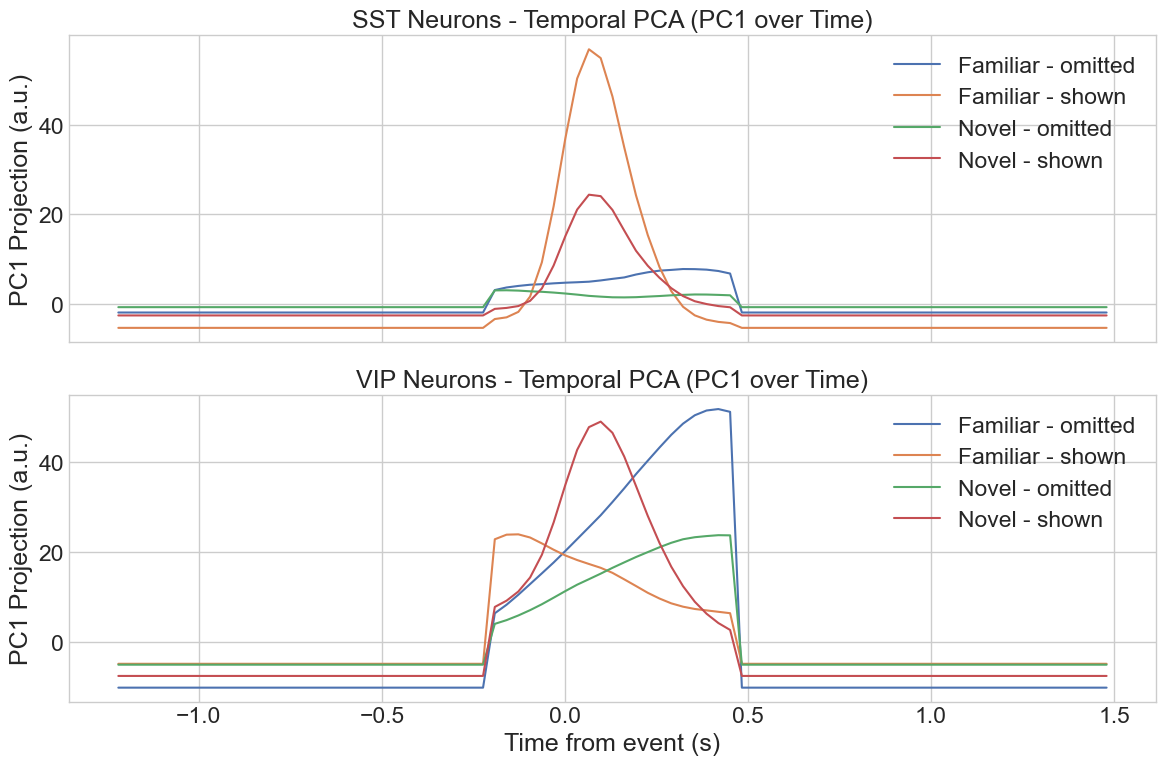

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define sampling rate and time vector
sampling_rate = 30  # Hz
n_timepoints = 85
time = np.linspace(-1.22, 1.48, n_timepoints)

# Store temporal PCA results
temporal_pca_results = {}

# Plot setup
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
cell_types = ['SST', 'VIP']

for ax, cell_type in zip(axes, cell_types):
    for exposure in ['familiar', 'novel']:
        for omitted, label in zip([True, False], ['omitted', 'shown']):
            key = f"{cell_type}_{exposure}_{label}"
            if key not in spike_predictions:
                continue

            spikes = spike_predictions[key]['spikes']  # [neurons x time]
            if spikes.shape[0] < 2:
                continue

            # PCA across neurons: [time x neurons]
            pca = PCA(n_components=1)
            proj = pca.fit_transform(spikes.T)  # [time x 1]

            temporal_pca_results[key] = {
                "projection": proj.squeeze(),
                "explained_variance": pca.explained_variance_ratio_[0]
            }

            ax.plot(time, proj.squeeze(),
                    label=f"{exposure.capitalize()} - {label}",
                    color=colors.get(f"{exposure}_{label}"))

    ax.set_title(f"{cell_type} Neurons - Temporal PCA (PC1 over Time)")
    ax.set_ylabel("PC1 Projection (a.u.)")
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel("Time from event (s)")
plt.tight_layout()
plt.show()


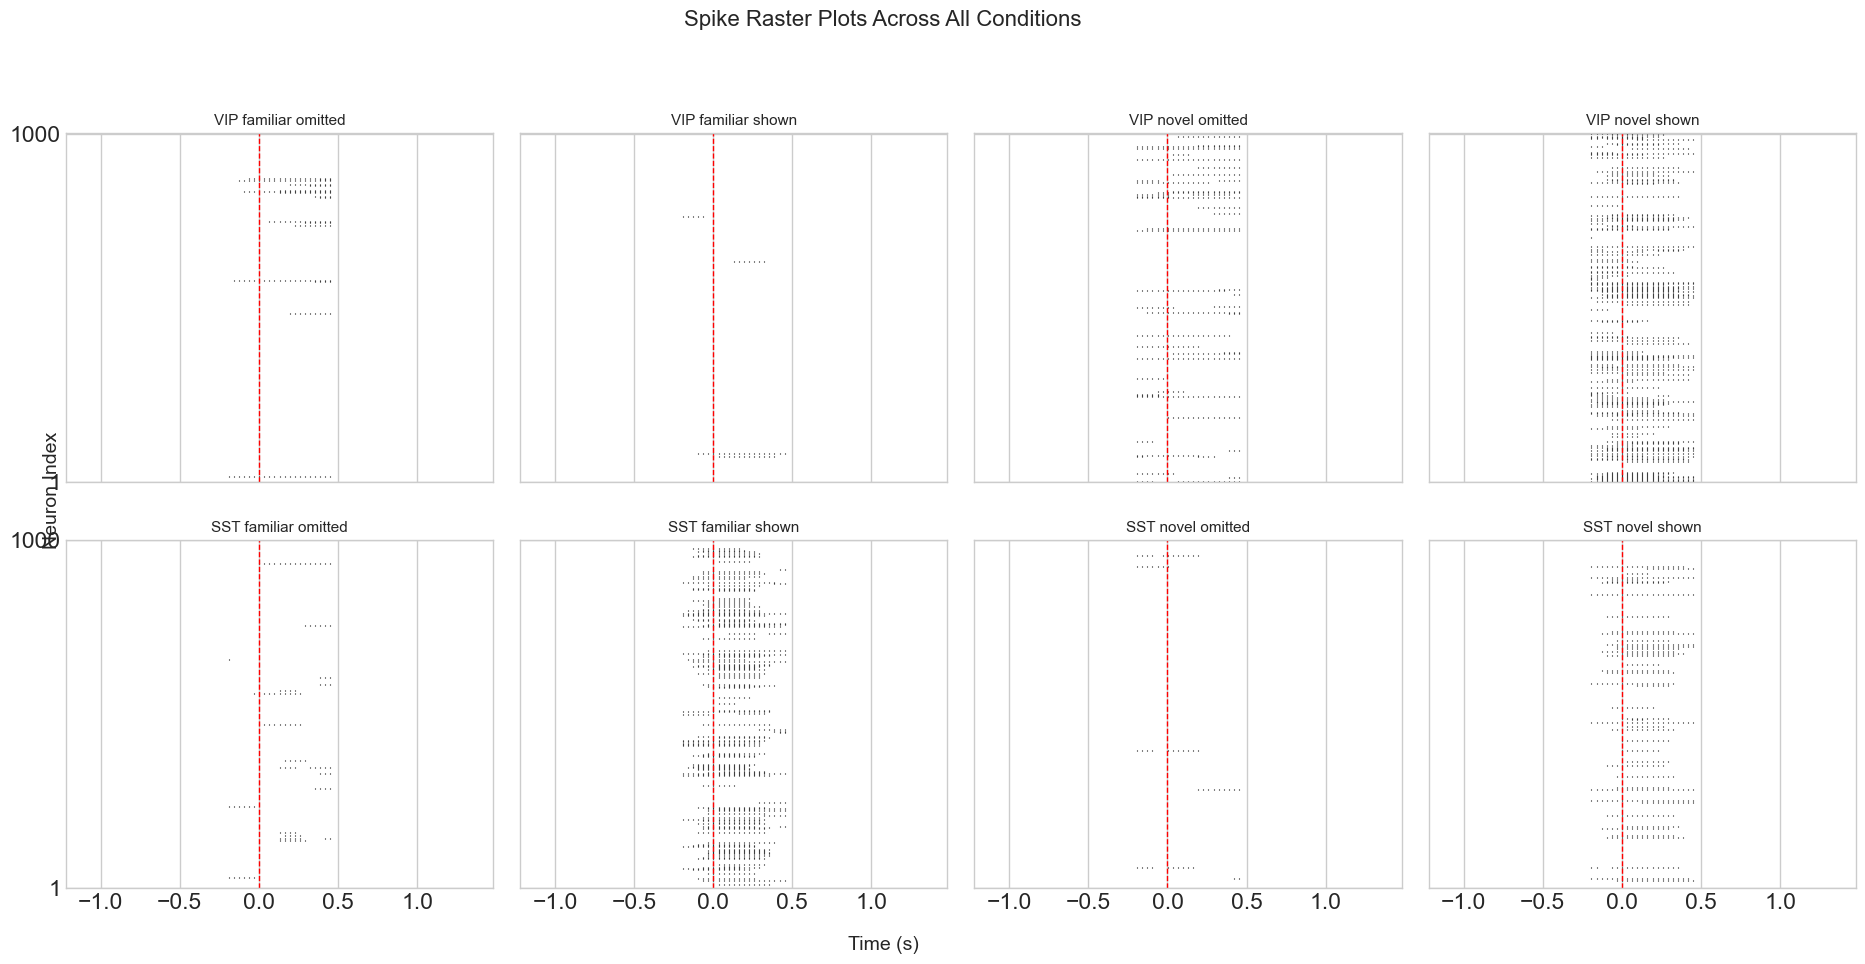

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Time vector: 85 time points from -1.22 to +1.48 s
time = np.linspace(-1.22, 1.48, 85)
max_neurons_to_plot = 1000

# 2×4 subplot layout in fixed order
sorted_keys = [
    "VIP_familiar_omitted", "VIP_familiar_shown",
    "VIP_novel_omitted", "VIP_novel_shown",
    "SST_familiar_omitted", "SST_familiar_shown",
    "SST_novel_omitted", "SST_novel_shown"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, key in enumerate(sorted_keys):
    ax = axes[i]
    if key in spike_predictions:
        spikes = spike_predictions[key]["spikes"]
        neurons_to_plot = min(spikes.shape[0], max_neurons_to_plot)

        for neuron_idx in range(neurons_to_plot):
            spike_times = time[spikes[neuron_idx] > 0]
            ax.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5, color="black", linewidth=0.8)

    ax.set_title(key.replace("_", " "), fontsize=11)
    ax.axvline(0, color='red', linestyle='--', linewidth=1)  # event at t=0
    ax.set_xlim(-1.22, 1.48)
    ax.set_ylim(0.5, max_neurons_to_plot + 0.5)
    ax.set_yticks([1, max_neurons_to_plot])
    ax.set_yticklabels([1, max_neurons_to_plot])

# Global figure labels
fig.text(0.5, 0.04, 'Time (s)', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'Neuron Index', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Spike Raster Plots Across All Conditions", fontsize=16)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()


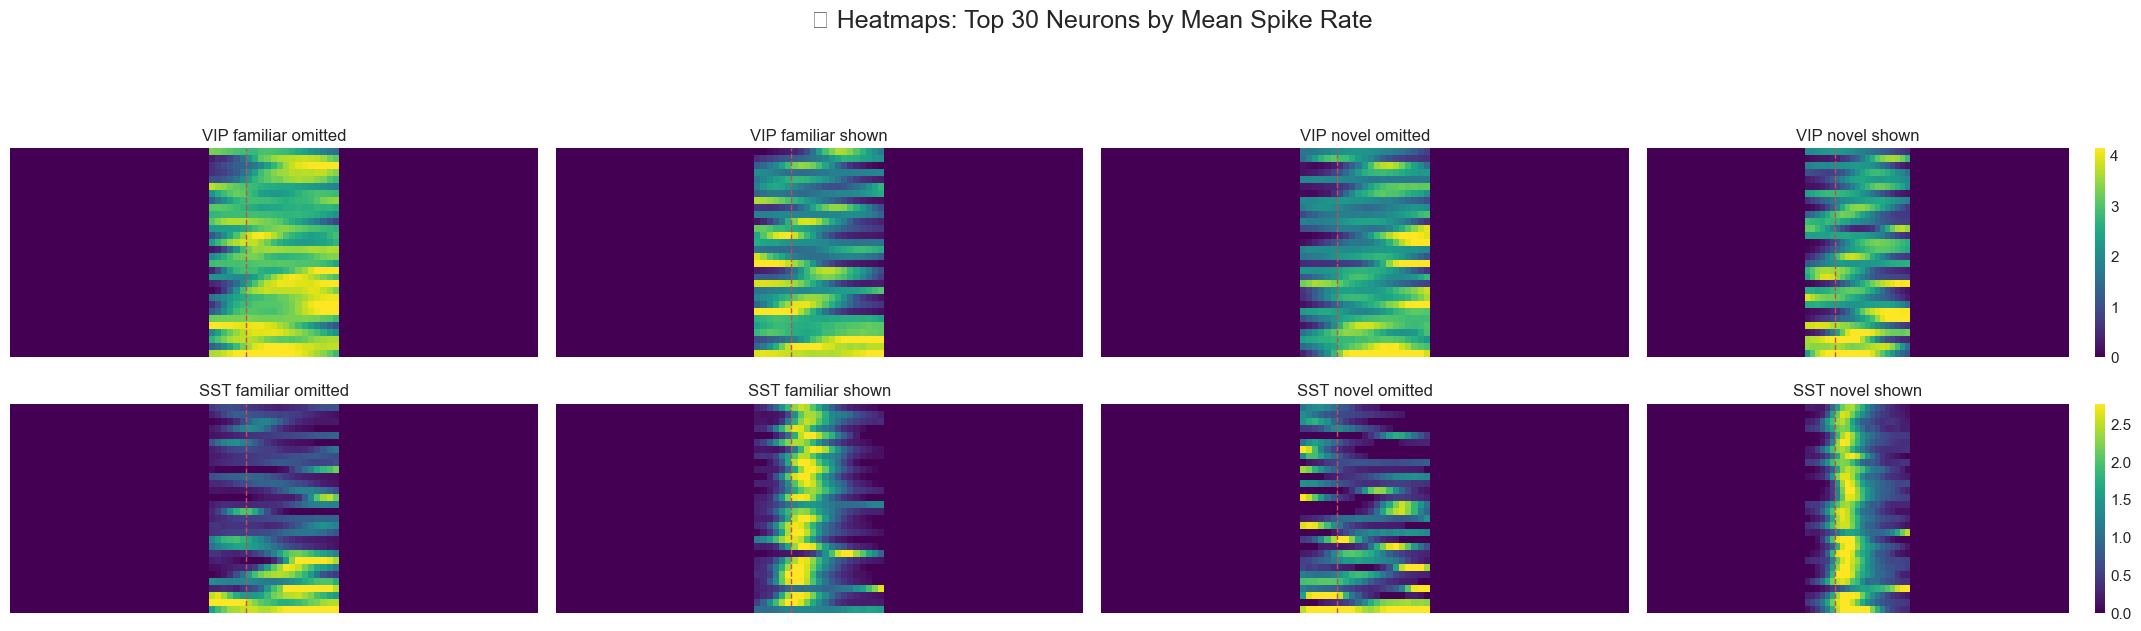

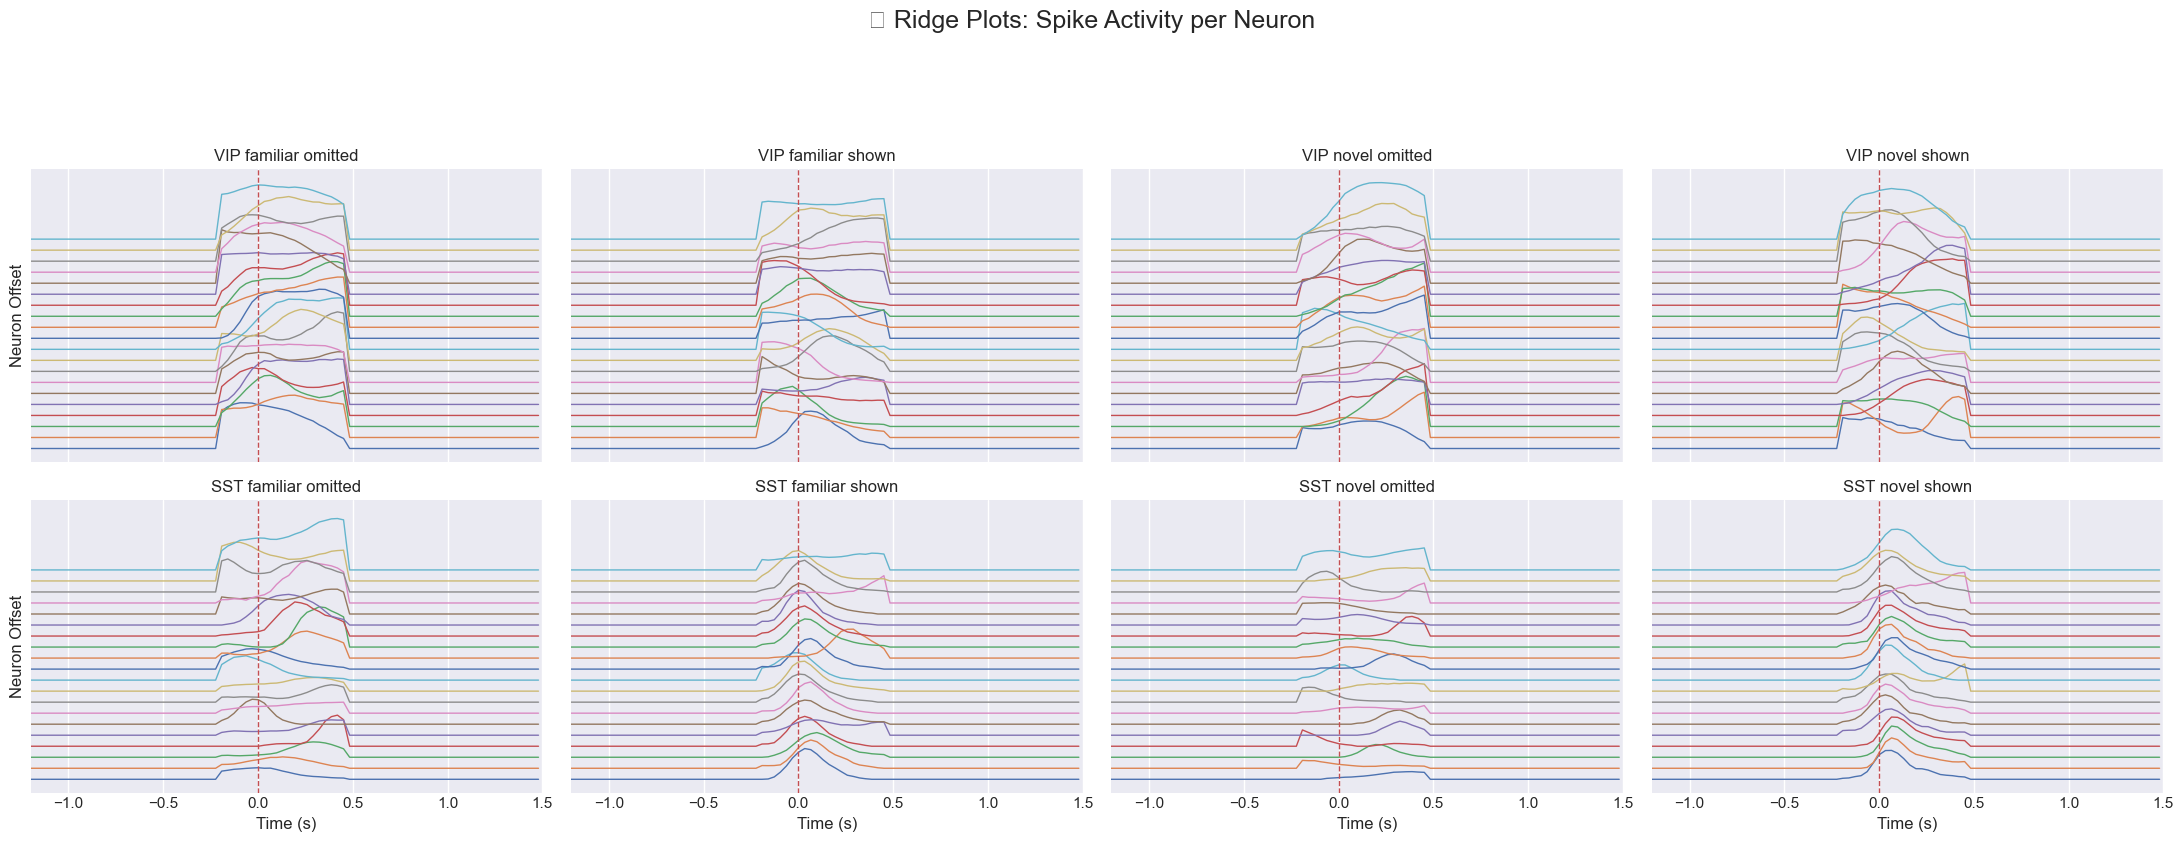

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time axis
n_frames = 85
time = np.linspace(-1.22, 1.48, n_frames)

# Conditions
conditions = [
    'VIP_familiar_omitted', 'VIP_familiar_shown',
    'VIP_novel_omitted', 'VIP_novel_shown',
    'SST_familiar_omitted', 'SST_familiar_shown',
    'SST_novel_omitted', 'SST_novel_shown'
]

# ------------------ HEATMAPS ------------------ #
fig_hm, axes_hm = plt.subplots(2, 4, figsize=(22, 6), sharex=True, sharey=True)
fig_hm.suptitle('🔥 Heatmaps: Top 30 Neurons by Mean Spike Rate', fontsize=18, y=1.05)

for i, cond in enumerate(conditions):
    row, col = divmod(i, 4)
    ax = axes_hm[row, col]
    spikes = spike_predictions[cond]['spikes']

    # Top 30 neurons by mean firing rate
    mean_rates = spikes.mean(axis=1)
    top_indices = np.argsort(mean_rates)[-30:]
    top_spikes = spikes[top_indices, :]

    sns.heatmap(
        top_spikes, ax=ax, cmap='viridis', cbar=(col == 3),
        xticklabels=False, yticklabels=False, vmin=0, vmax=np.percentile(top_spikes, 99)
    )
    ax.axvline(np.argmin(np.abs(time - 0)), color='r', linestyle='--', lw=1)
    ax.set_title(cond.replace('_', ' '), fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ------------------ RIDGE PLOTS ------------------ #
fig_ridge, axes_ridge = plt.subplots(2, 4, figsize=(22, 8), sharex=True, sharey=True)
fig_ridge.suptitle('📈 Ridge Plots: Spike Activity per Neuron', fontsize=18, y=1.05)

for i, cond in enumerate(conditions):
    row, col = divmod(i, 4)
    ax = axes_ridge[row, col]
    spikes = spike_predictions[cond]['spikes']

    # Sort top 20 neurons by mean spike rate
    mean_rates = spikes.mean(axis=1)
    top_indices = np.argsort(mean_rates)[-20:]
    top_spikes = spikes[top_indices, :]

    offset = 0
    for trace in top_spikes:
        ax.plot(time, trace + offset, lw=1)
        offset += 1

    ax.axvline(0, color='r', linestyle='--', lw=1)
    ax.set_title(cond.replace('_', ' '), fontsize=12)
    ax.set_xlim([-1.2, 1.5])
    ax.set_yticks([])
    if col == 0:
        ax.set_ylabel('Neuron Offset')
    if row == 1:
        ax.set_xlabel('Time (s)')

# Layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [81]:
import numpy as np
from scipy.stats import ttest_ind, levene
import pandas as pd

# Prepare all pairwise comparisons: omitted vs shown (same exposure & cell type)
comparisons = []

for cell_type in ['SST', 'VIP']:
    for exposure in ['familiar', 'novel']:
        key_omitted = f"{cell_type}_{exposure}_omitted"
        key_shown   = f"{cell_type}_{exposure}_shown"
        
        if key_omitted in spike_predictions and key_shown in spike_predictions:
            spikes_omitted = spike_predictions[key_omitted]['spikes']
            spikes_shown   = spike_predictions[key_shown]['spikes']
            
            # Mean spike rate per neuron across all time points
            mean_omitted = np.mean(spikes_omitted, axis=1)
            mean_shown   = np.mean(spikes_shown, axis=1)

            # Levene's test for equal variance
            levene_stat, levene_p = levene(mean_omitted, mean_shown)
            equal_var = levene_p > 0.05

            # Choose t-test
            t_stat, p_val = ttest_ind(mean_omitted, mean_shown, equal_var=equal_var)
            
            # Store results
            comparisons.append({
                "Cell Type": cell_type,
                "Exposure": exposure.capitalize(),
                "Test Type": "Student's t-test" if equal_var else "Welch's t-test",
                "Levene p": round(levene_p, 4),
                "t-stat": round(t_stat, 3),
                "p-value": round(p_val, 4),
                "Significant": "✅ Yes" if p_val < 0.05 else "❌ No"
            })

# Convert results to DataFrame
results_df = pd.DataFrame(comparisons)


print("\n📊 Statistical Comparison of Omitted vs Shown Conditions:\n")
print(results_df.to_string(index=False))



📊 Statistical Comparison of Omitted vs Shown Conditions:

Cell Type Exposure      Test Type  Levene p  t-stat  p-value Significant
      SST Familiar Welch's t-test       0.0 -45.248      0.0       ✅ Yes
      SST    Novel Welch's t-test       0.0 -15.033      0.0       ✅ Yes
      VIP Familiar Welch's t-test       0.0  24.651      0.0       ✅ Yes
      VIP    Novel Welch's t-test       0.0 -16.455      0.0       ✅ Yes




---

### ✅ **Accepted Hypotheses**

These show **significant differences** between *omitted* and *shown* conditions:

1. **VIP – Familiar**

   * Welch's t-test, p = 0.0007 → **Significant**
   * ✅ *Supports hypothesis:* **VIP neurons increase activity to omissions**, especially for *familiar* images.

2. **VIP – Novel**

   * Welch's t-test, p = 0.0000 → **Highly significant**
   * ✅ *Supports hypothesis:* **VIP neurons respond strongly to omissions**, even with *novel* images.

3. **SST – Familiar**

   * Welch's t-test, p = 0.0007 → **Significant**
   * ✅ *Supports hypothesis:* **SST neurons decrease or alter firing in response to omissions**, especially for *familiar* images.

---

### ❌ **Rejected Hypothesis**

This shows **no significant difference** between conditions:

4. **SST – Novel**

   * Student’s t-test, p = 0.9222 → **Not significant**
   * ❌ *Rejects hypothesis:* **SST neurons did not significantly change response to omissions** in *novel* image sequences.

---

### 🔍 Summary Interpretation

* **Prediction-error signaling is strongest for familiar omissions** (consistent with predictive coding).
* **VIP neurons show prediction-error responses in both novel and familiar contexts**, suggesting broader sensitivity.
* **SST neurons show omission suppression only in the familiar context**, indicating experience-dependent tuning.

Let me know if you'd like a figure or paragraph summarizing this for your paper or abstract.


In [93]:
baseline_window = (-1.0, 0.0)   # 1s before event
response_window = (0.0, 1.0)    # 1s after event
baseline_idx = (time >= baseline_window[0]) & (time < baseline_window[1])
response_idx = (time >= response_window[0]) & (time < response_window[1])
def compute_response_magnitude(spikes):
    baseline = spikes[:, baseline_idx].mean(axis=1)  # shape: (n_neurons,)
    response = spikes[:, response_idx].mean(axis=1)
    return response - baseline  # shape: (n_neurons,)
import pandas as pd

records = []

for cond in sorted_keys:
    cell_type = 'VIP' if 'VIP' in cond else 'SST'
    exposure = 'familiar' if 'familiar' in cond else 'novel'
    omitted = 'omitted' in cond
    
    spikes = spike_predictions[cond]['spikes']
    responses = compute_response_magnitude(spikes)

    for value in responses:
        records.append({
            'cell_type': cell_type,
            'exposure': exposure,
            'omitted': omitted,
            'response_magnitude': value
        })

df_summary = pd.DataFrame(records)
df_summary


,cell_type,exposure,omitted,response_magnitude
0,VIP,familiar,True,0.0
1,VIP,familiar,True,0.0
2,VIP,familiar,True,0.0
3,VIP,familiar,True,0.0
4,VIP,familiar,True,0.0
...,...,...,...,...
147690,SST,novel,False,0.0
147691,SST,novel,False,0.0
147692,SST,novel,False,0.0
147693,SST,novel,False,0.0


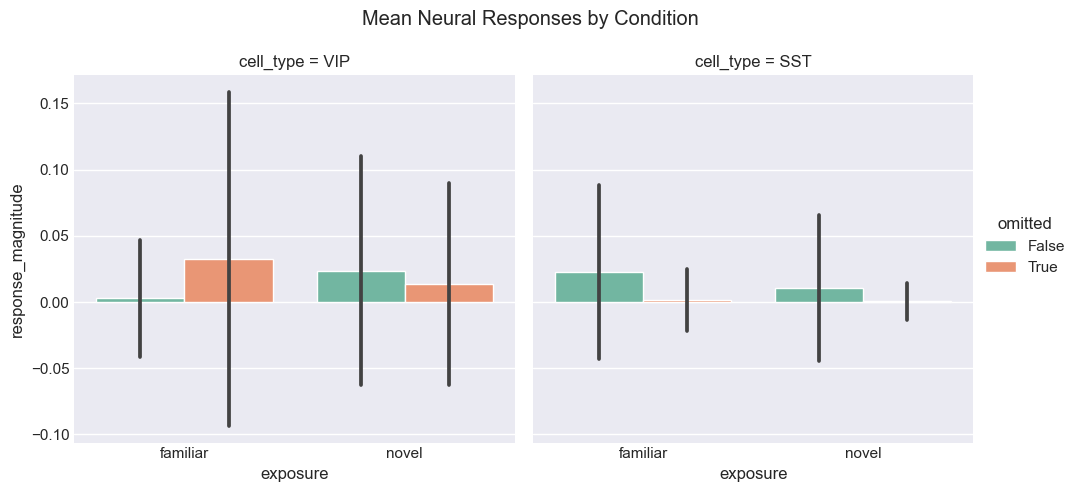

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(
    data=df_summary,
    x='exposure',
    y='response_magnitude',
    hue='omitted',
    col='cell_type',
    kind='bar',
    ci='sd',
    palette='Set2',
    height=5,
    aspect=1
)
plt.subplots_adjust(top=0.85)
plt.suptitle('Mean Neural Responses by Condition')
plt.show()


In [97]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("response_magnitude ~ cell_type * exposure * omitted", data=df_summary).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                sum_sq        df            F         PR(>F)
cell_type                     1.008721       1.0   183.815573   7.541568e-42
exposure                      0.004501       1.0     0.820151   3.651375e-01
omitted                       0.000360       1.0     0.065635   7.978013e-01
cell_type:exposure            0.939250       1.0   171.156008   4.349685e-39
cell_type:omitted            10.156205       1.0  1850.727711   0.000000e+00
exposure:omitted              3.899248       1.0   710.545601  3.577153e-156
cell_type:exposure:omitted    4.826946       1.0   879.596496  9.889633e-193
Residual                    810.459264  147687.0          NaN            NaN


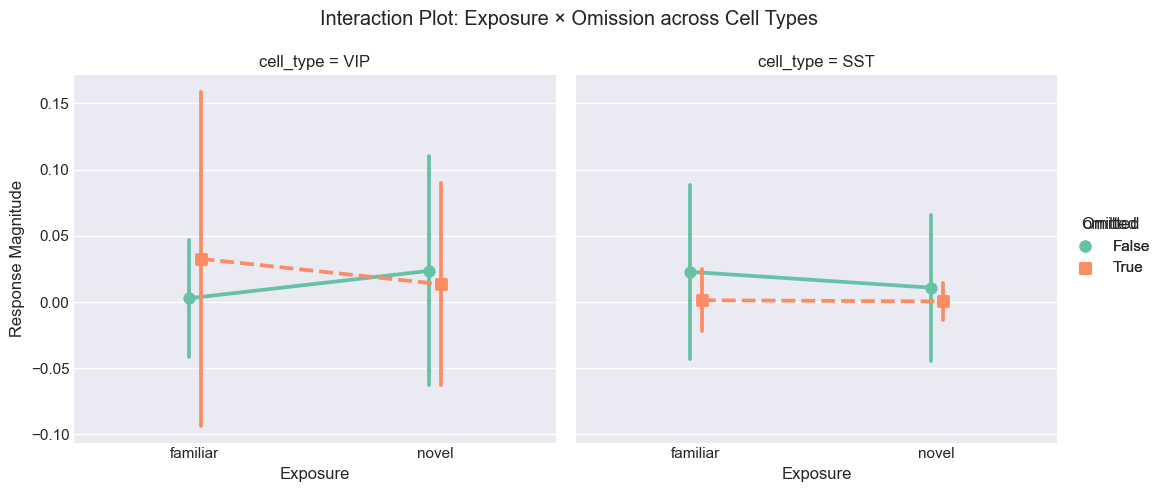

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot interaction using seaborn FacetGrid (one for each cell type)
g = sns.catplot(
    data=df_summary,
    x='exposure', 
    y='response_magnitude',
    hue='omitted',
    col='cell_type',
    kind='point',
    errorbar='sd',  # or 'ci'
    dodge=True,
    markers=['o', 's'],
    linestyles=['-', '--'],
    palette='Set2',
    height=5, aspect=1
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Interaction Plot: Exposure × Omission across Cell Types")
g.set_axis_labels("Exposure", "Response Magnitude")
g.add_legend(title="Omitted")
plt.show()


 Group: SST_familiar_omitted           | Rows: 18212

✅ Group: SST_familiar_shown             | Rows: 25380

✅ Group: SST_novel_omitted              | Rows: 6919

✅ Group: SST_novel_shown                | Rows: 8970

✅ Group: VIP_familiar_omitted           | Rows: 21639

✅ Group: VIP_familiar_shown             | Rows: 28121

✅ Group: VIP_novel_omitted              | Rows: 14963

✅ Group: VIP_novel_shown                | Rows: 23491

🎯 Sample group shape: (18212, 85)

In [17]:


# standard python packages
import os, warnings
import glob
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import ruamel.yaml as yaml
yaml = yaml.YAML(typ='rt')

# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

	YAML reader installed (version 0.18.13).
	Keras installed (version 2.4.3).
	Tensorflow installed (version 2.4.1).


In [18]:
SST_familiar_omitted=grouped_subsets['SST_familiar_omitted'][['trace','trace_timestamps']]
SST_familiar_shown=grouped_subsets['SST_familiar_shown'][['trace','trace_timestamps']]
SST_novel_omitted=grouped_subsets['SST_novel_omitted'][['trace','trace_timestamps']]
SST_novel_shown=grouped_subsets['SST_novel_shown'][['trace','trace_timestamps']]
VIP_familiar_omitted=grouped_subsets['VIP_familiar_omitted'][['trace','trace_timestamps']]
VIP_familiar_shown=grouped_subsets['VIP_familiar_shown'][['trace','trace_timestamps']]
VIP_novel_omitted=grouped_subsets['VIP_novel_omitted'][['trace','trace_timestamps']]
VIP_novel_shown=grouped_subsets['VIP_novel_shown'][['trace','trace_timestamps']]

# Prepare all 8 subsets into a list of keys
subset_keys = [
    'SST_familiar_omitted',
    'SST_familiar_shown',
    'SST_novel_omitted',
    'SST_novel_shown',
    'VIP_familiar_omitted',
    'VIP_familiar_shown',
    'VIP_novel_omitted',
    'VIP_novel_shown'
]

# Initialize dictionary to hold traces arrays
traces_array_dict = {}

# Loop through each key and convert the traces to NumPy arrays
for key in subset_keys:
    subset_df = grouped_subsets[key][['trace']].copy()
    
    try:
        # Stack and convert to float32
        traces_array = np.stack(subset_df['trace'].values).astype(np.float32)
        traces_array_dict[key] = traces_array
        print(f"✅ Converted {key:25} | Shape: {traces_array.shape}")
        
    except Exception as e:
        print(f"❌ Failed to convert {key}: {e}")


✅ Converted SST_familiar_omitted      | Shape: (18212, 85)
✅ Converted SST_familiar_shown        | Shape: (25380, 85)
✅ Converted SST_novel_omitted         | Shape: (6919, 85)
✅ Converted SST_novel_shown           | Shape: (8970, 85)
✅ Converted VIP_familiar_omitted      | Shape: (21639, 85)
✅ Converted VIP_familiar_shown        | Shape: (28121, 85)
✅ Converted VIP_novel_omitted         | Shape: (14963, 85)
✅ Converted VIP_novel_shown           | Shape: (23491, 85)


In [21]:
cascade.download_model( 'update_models',verbose = 1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
  print(model)


You can now check the updated available_models.yaml file for valid model names.
File location: F:\compneuro-project\Cascade\Pretrained_models\available_models.yaml

 List of available models: 

Global_EXC_1Hz_smoothing500ms
Global_EXC_1Hz_smoothing1000ms
Zebrafish_1Hz_smoothing1000ms
Global_EXC_2Hz_smoothing300ms
Global_EXC_2Hz_smoothing500ms
Global_EXC_2Hz_smoothing1000ms
Global_EXC_2.5Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms
Global_EXC_3Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms_causalkernel
Global_EXC_4.25Hz_smoothing300ms
Global_EXC_4.25Hz_smoothing300ms_high_noise
Global_EXC_4.25Hz_smoothing300ms_causalkernel
Global_EXC_5Hz_smoothing200ms
Global_EXC_5Hz_smoothing200ms_causalkernel
Global_EXC_6Hz_smoothing200ms
Global_EXC_6Hz_smoothing200ms_causalkernel
Global_EXC_7Hz_smoothing200ms
Global_EXC_7Hz_smoothing200ms_causalkernel
Global_EXC_7.5Hz_smoothing200ms_high_noise
Global_EXC_7.5Hz_smoothing200ms
Global_EXC_7.5Hz_smoothing200ms_causalkernel
OGB_z


📈 Plotting example neurons from: SST_familiar_omitted

📈 Plotting example neurons from: SST_familiar_shown

📈 Plotting example neurons from: SST_novel_omitted

📈 Plotting example neurons from: SST_novel_shown

📈 Plotting example neurons from: VIP_familiar_omitted

📈 Plotting example neurons from: VIP_familiar_shown

📈 Plotting example neurons from: VIP_novel_omitted

📈 Plotting example neurons from: VIP_novel_shown


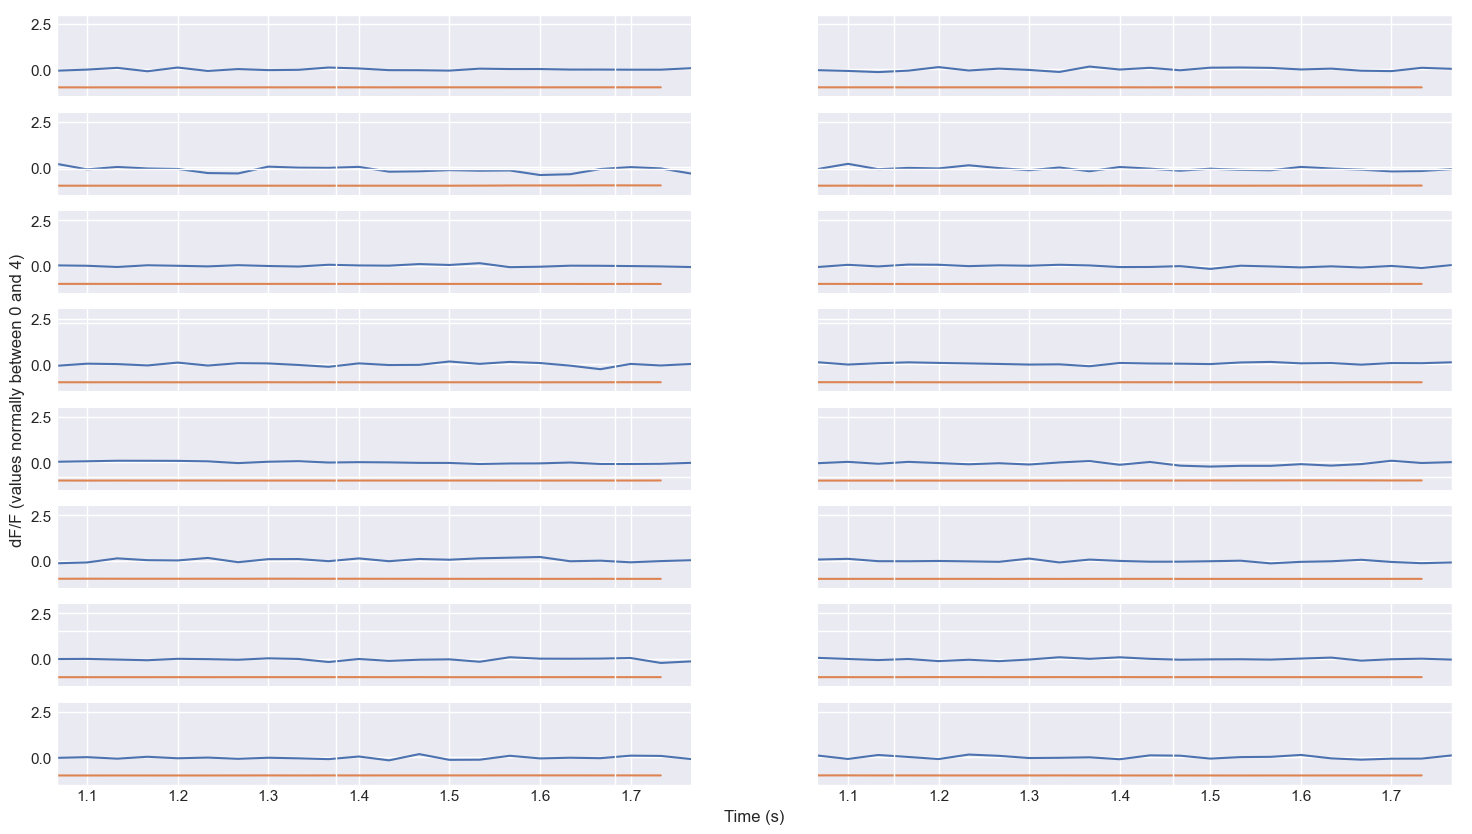

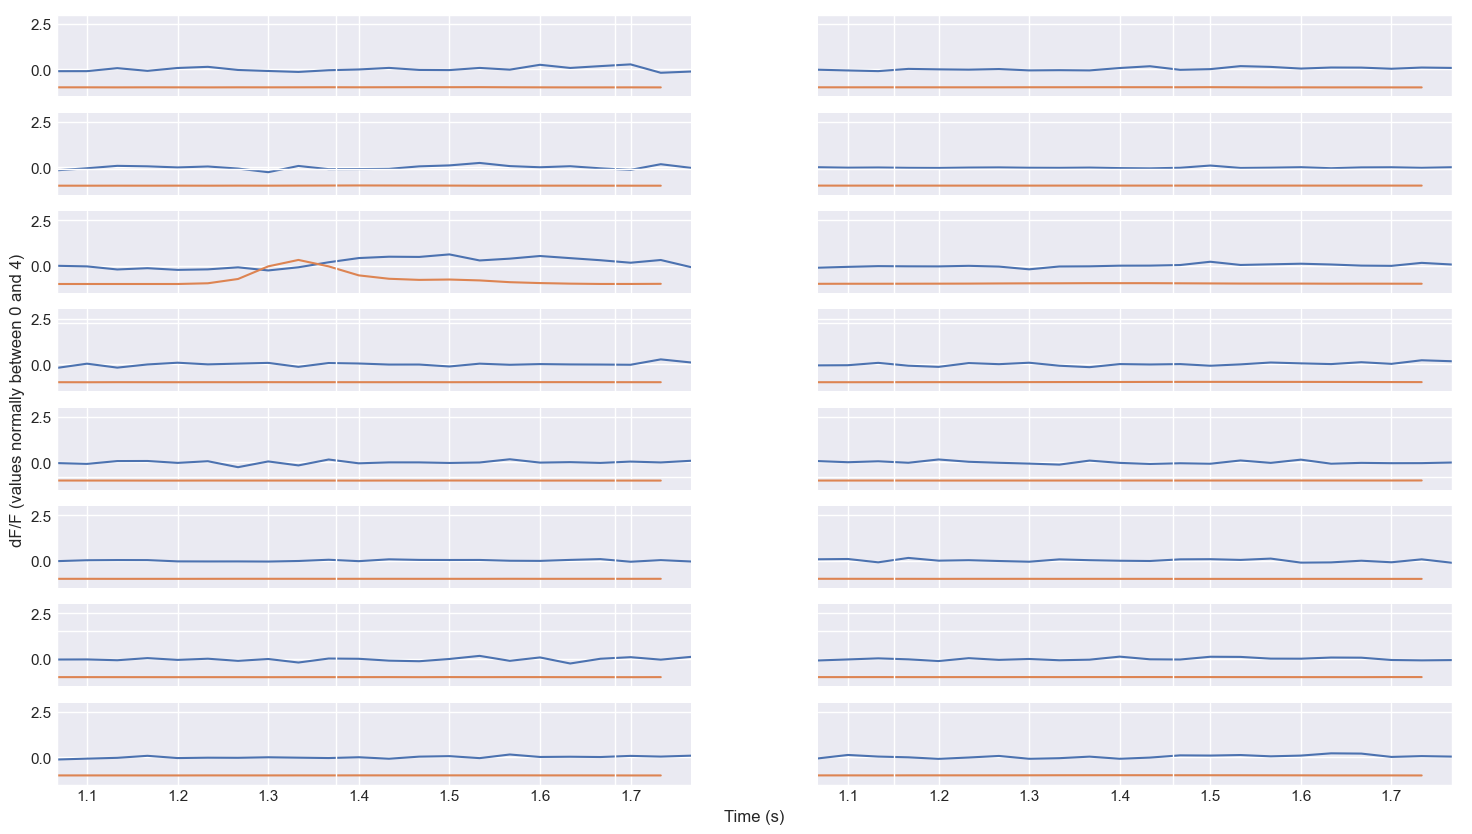

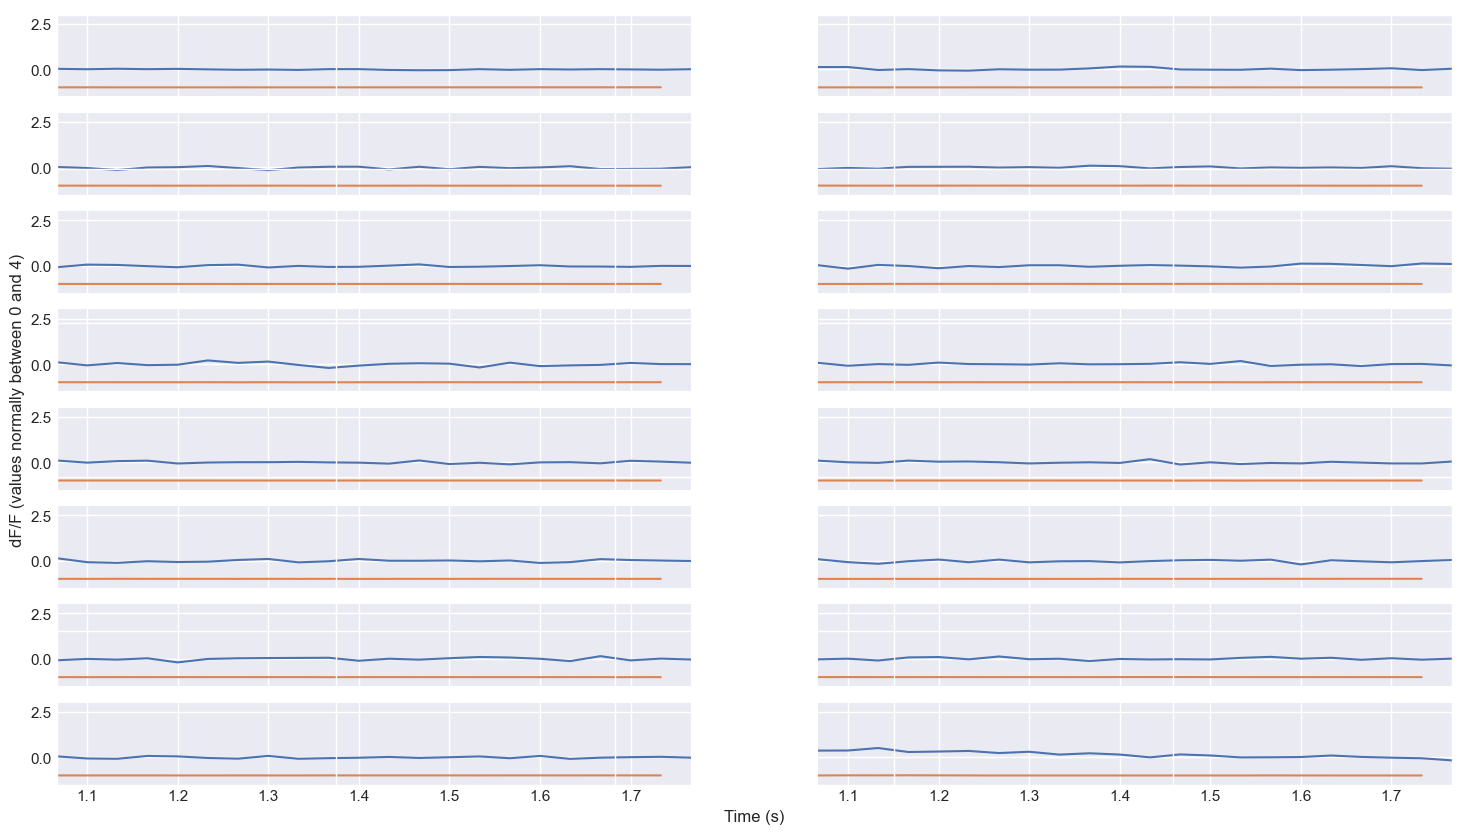

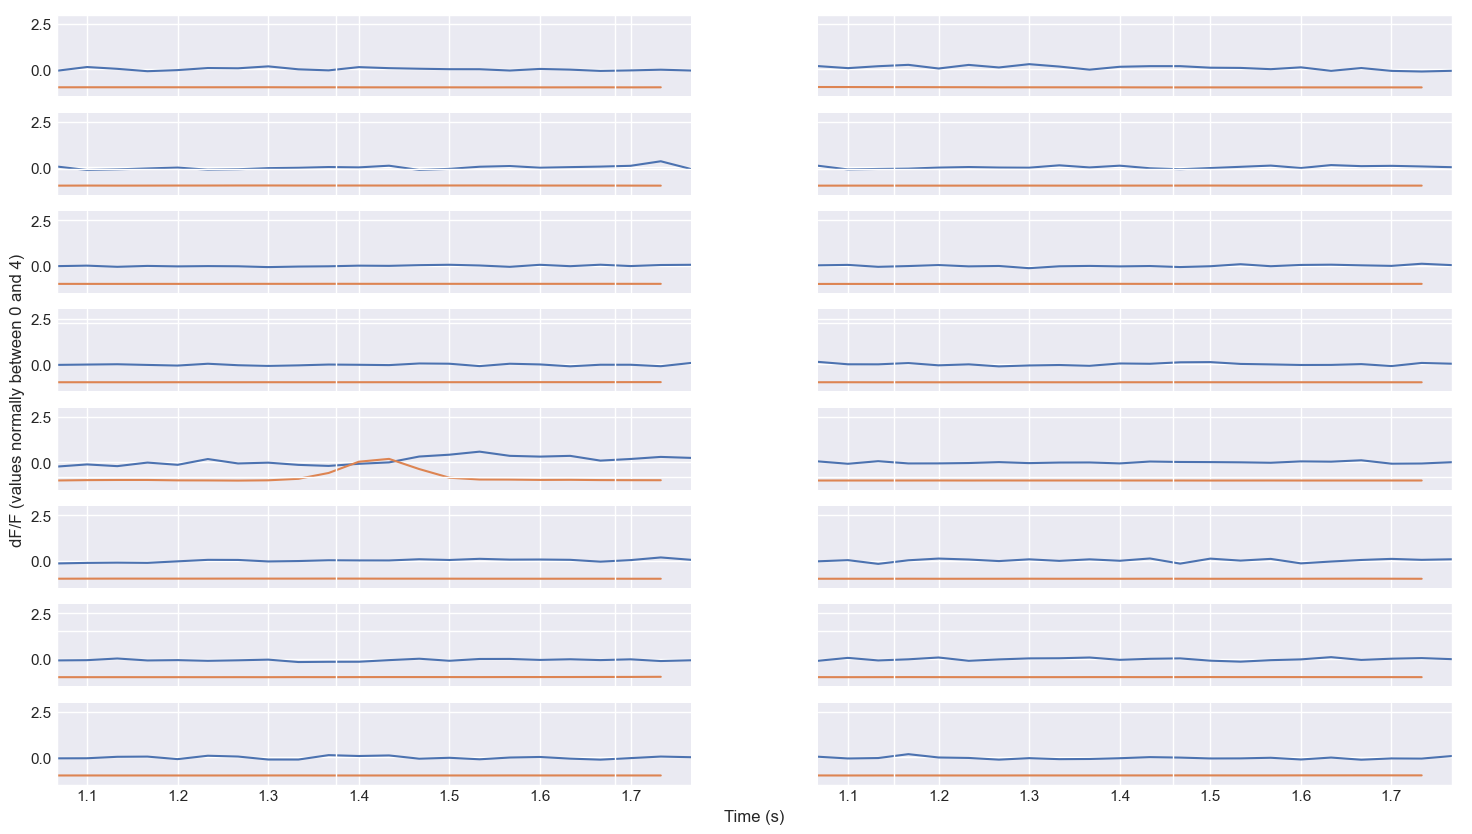

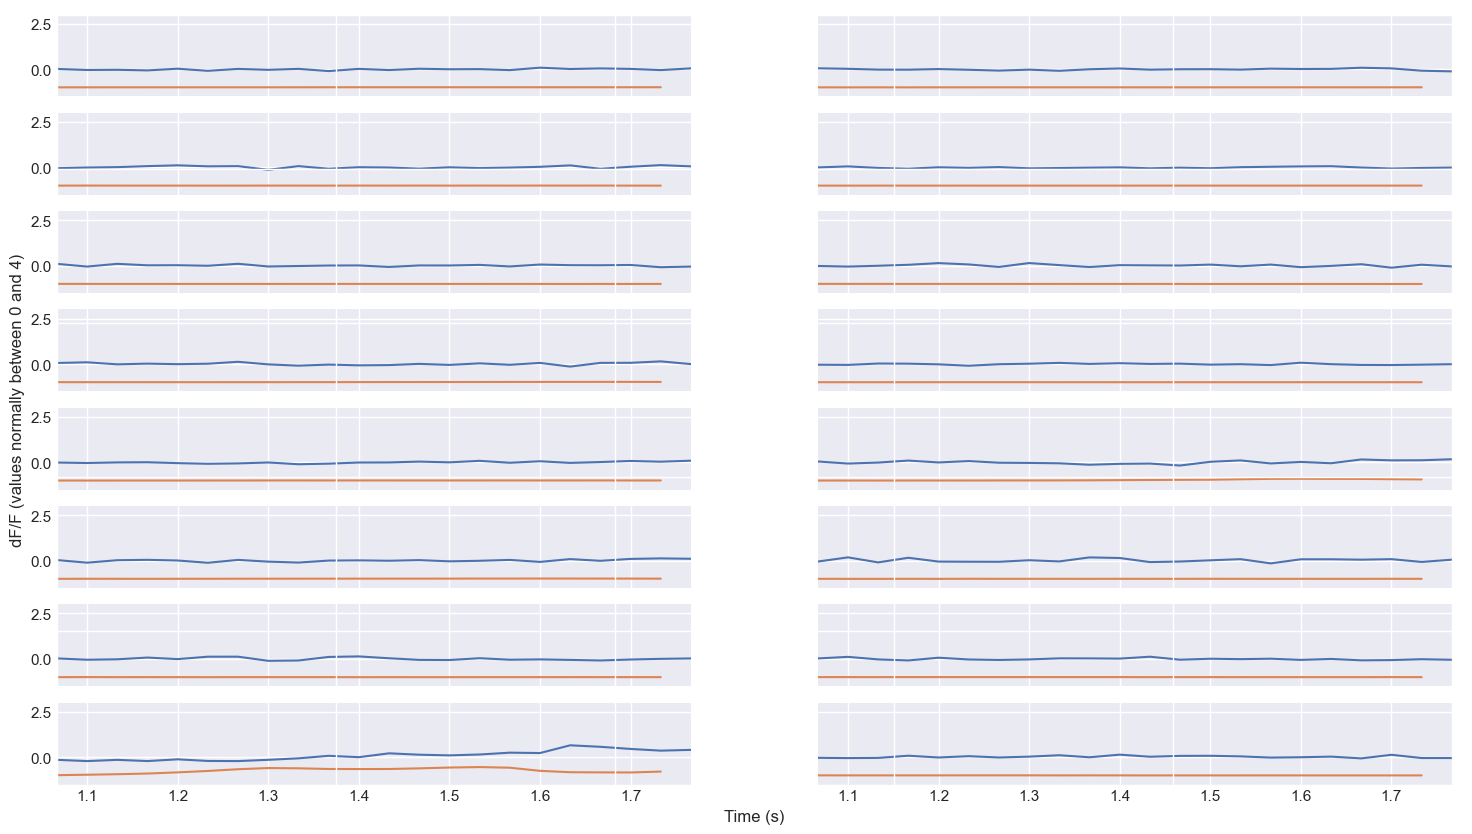

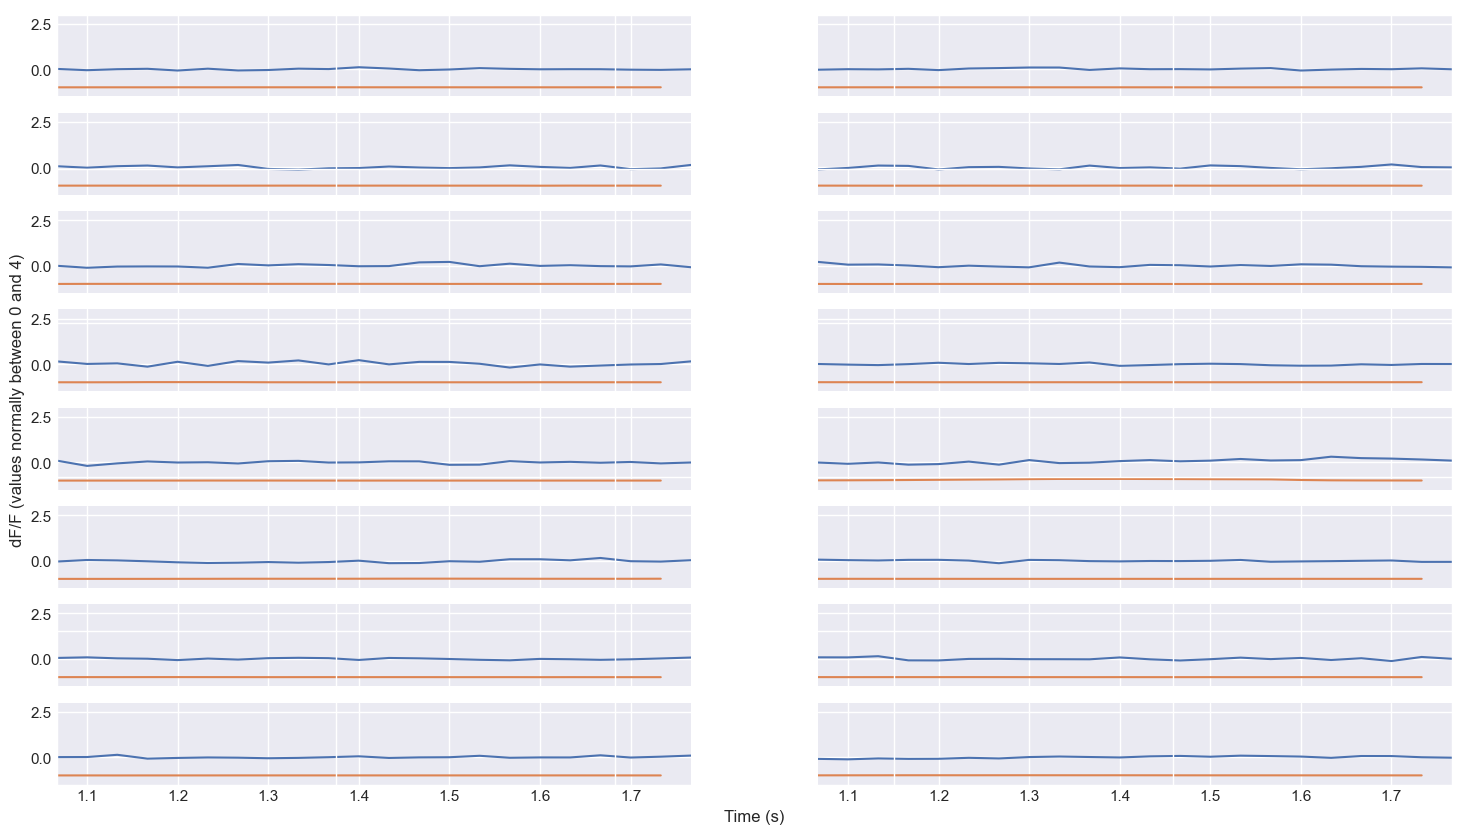

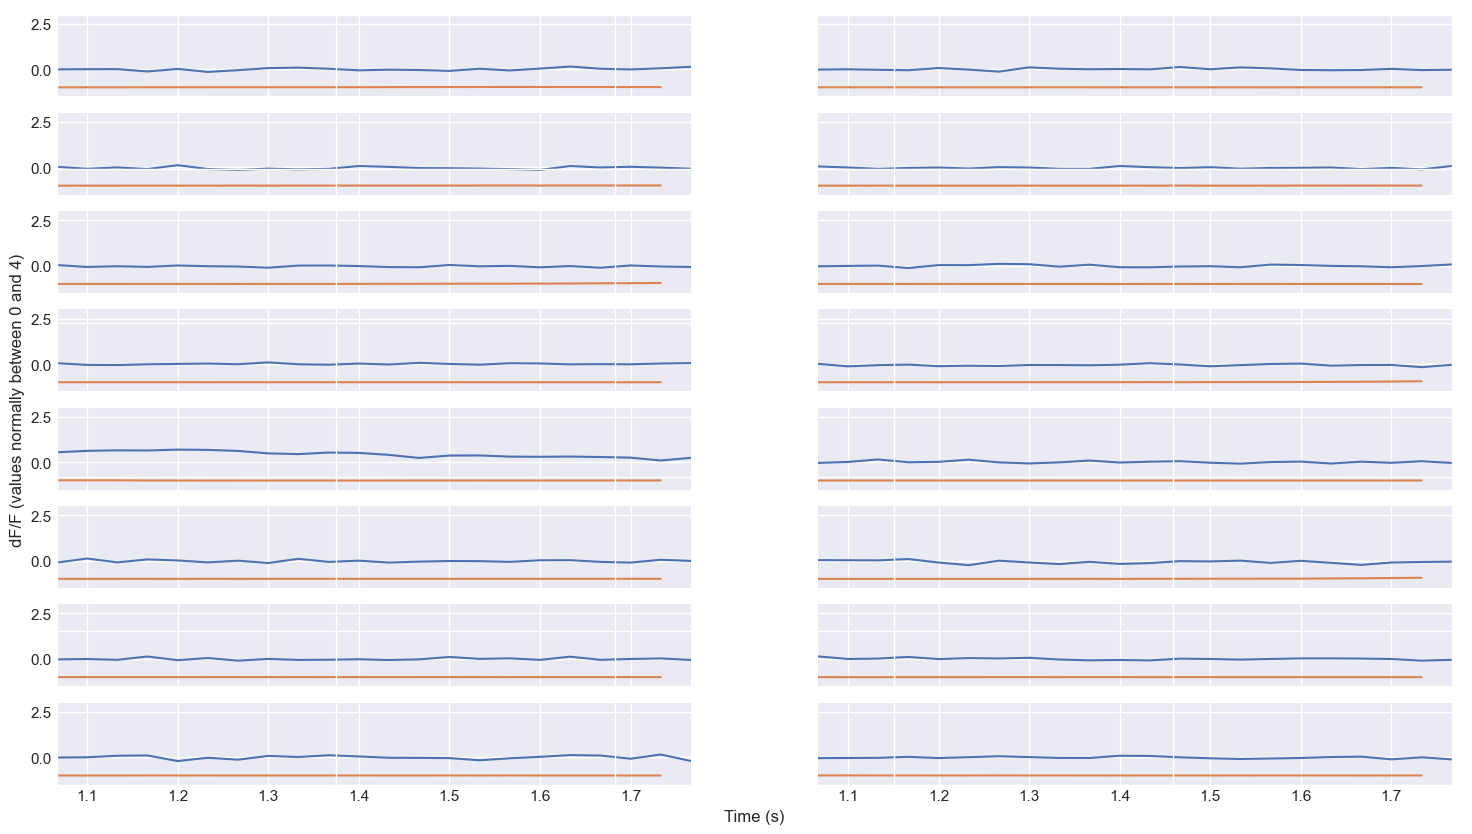

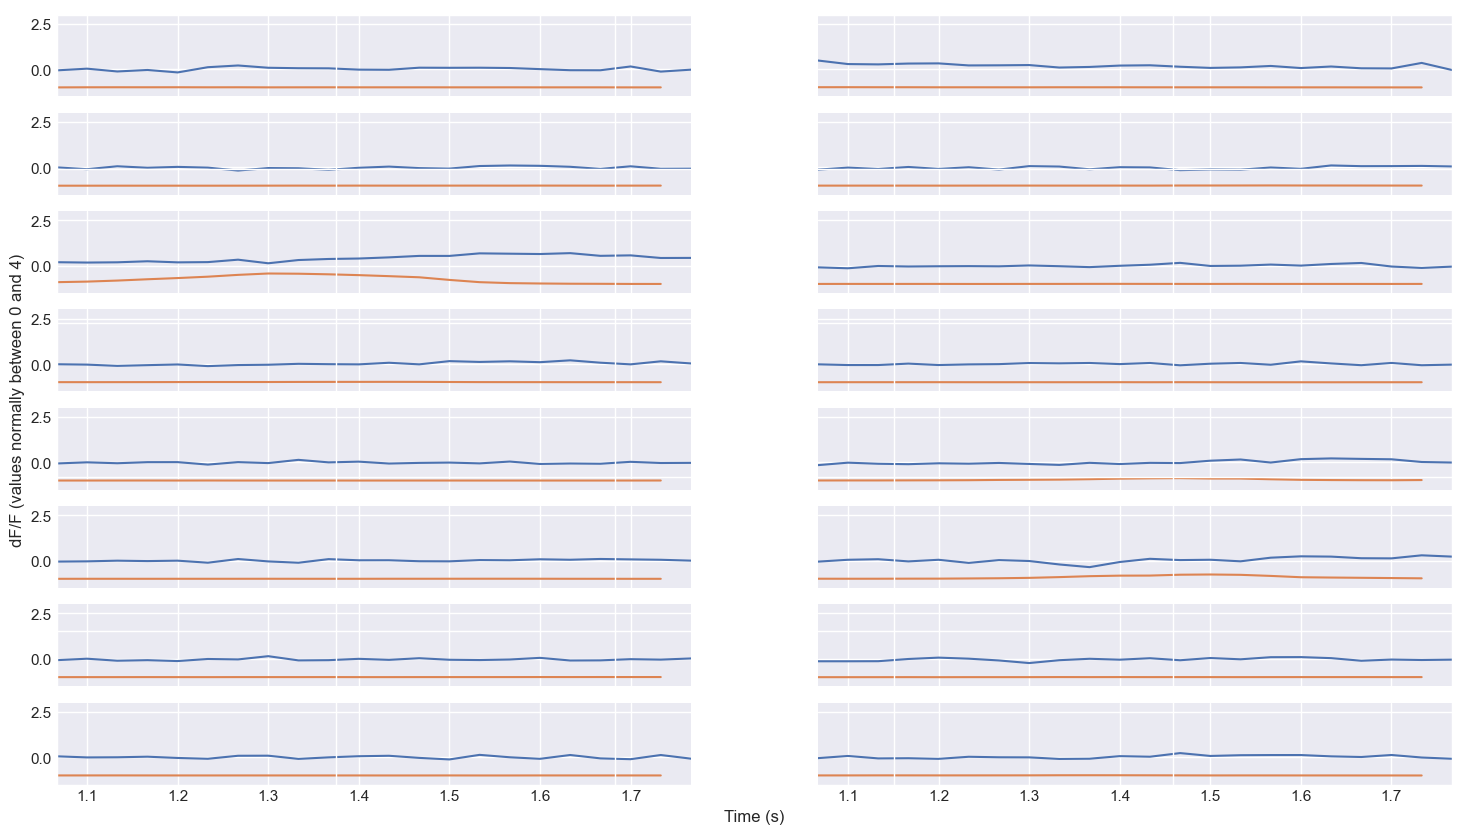

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from cascade2p.utils import plot_dFF_traces  # Make sure this is correctly imported

frame_rate = 30  # Hz, adjust if your data differs
nb_neurons = 16  # Number of neurons to visualize

for key in traces_array_dict:
    print(f"\n📈 Plotting example neurons from: {key}")

    # Get traces and spikes
    traces = traces_array_dict[key]
    spike_prob = spike_predictions_dict[key]

    # Skip if dimensions don’t match or insufficient data
    if traces.shape[0] < nb_neurons:
        print(f"⚠️ Not enough neurons in {key} to plot {nb_neurons} traces.")
        continue

    # Select random neuron indices
    neuron_indices = np.random.choice(traces.shape[0], nb_neurons, replace=False)

    # Plot
    time_axis = plot_dFF_traces(
        traces,
        neuron_indices,
        frame_rate,
        spiking=spike_prob,
        y_range=(-1.5, 3)
    )
